In [50]:
# Python packages and utilities
import os
from datetime import datetime
import pandas as pd
import numpy as np
from IPython.display import display, HTML

import mlxtend


#RDKit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import Crippen
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs

# Mordred
try:
    import mordred
    from mordred import Calculator, descriptors
except ModuleNotFoundError:
    !pip install 'mordred[full]'
    import mordred
    from mordred import Calculator, descriptors
    

# scikit-learn
import sklearn

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.feature_selection import RFECV, RFE
from sklearn import svm
from sklearn.linear_model import LassoCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import linear_model
kernel = DotProduct() + WhiteKernel()

try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns

# matplotlib
import matplotlib.pyplot as plt

# scikitplot library
try:
    import scikitplot as skplt
except ModuleNotFoundError:
    !pip install scikit-plot
    import scikitplot as skplt


# own module
from pythia import classification_metrics as cmetrics
from pythia import fingerprints_generation as fp
from pythia import molecules_and_structures as ms
from pythia import plots as pltsk
from pythia import workflow_functions as wf

# utility
%load_ext autoreload
%autoreload 2
%aimport
import importlib


import logging 
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)


random_seed = 10459
np.random.seed = random_seed
np.random.RandomState(random_seed)
log.info(f"Random seed fixed as {random_seed}")

Random seed fixed as 10459


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

# Load target data

First we read the dataset from a csv file. A csv file is a comma separated file, where each row is a data point.

`pd.read_csv()` is used to read the input csv file that contain the dataset. The dataset is stored in a dataframe, which is a data structure provided by the pandas library. A dataframe is a two-dimensional data structure, i.e. data is aligned in a tabular fashion in rows and columns. The dataframe can be indexed by column names.

Here, we also reformat the column names to replace spaces with underscores and make the column names all lower case. This is done to make it easier to work with the data.

In [3]:
data = pd.read_csv("First_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

In [4]:
log.info("Columns: {}".format(data.columns))

Columns: Index(['reaction', 'substrate', 'catalyst', 'solvent', 'solvent_code',
       'temperature', 'ee', 'ddg', 'paper'],
      dtype='object')


# Set Target Properties

Here we define the input column and the target column. 

In chemistry, we usually use SMILES to represent molecules. SMILES is a string representation of a molecule. These SMILES strings should be obtained during data collection. Here we define the column name that contains the SMILES strings. 

The target values are the values that we want to predict. In this case, the target column is the column that contains the ddg values. 

In [5]:
substratesmiles = data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles.head()))

catalystsmiles = data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles.head()))

reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

temp = data["temperature"]
log.info("Temperature: {}".format(temp.head()))

ddg = data["ddg"]
log.info("DGG: {}".format(ddg.head()))


Substrate SMILES: 0         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
1    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
2         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
3    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
4         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
Name: substrate, dtype: object
Catalyst SMILES: 0    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
1    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
2    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
3    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
4    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
Name: catalyst, dtype: object
Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64
Temperature: 0   -30.0
1   -30.0
2   -30.0
3   -30.0
4   -30.0
Name: temperature, dtype: float64
DGG: 0    0.569810
1    1.761325
2    1.251493
3    5.229434
4    2.678563
Name: ddg, dtype: float64


In [6]:
targets = ddg

Here I make a folder to save the results of this Notebook separately

In [7]:
os.makedirs("results_reg_mordred", exist_ok=True)
os.chdir("results_reg_mordred")

# Generate Mordred Descriptors as Features

We first convert the SMILES strings into RDKit molecules. RDKit is a cheminformatics software that can be used to manipulate molecules. 

Then we use the `Mordred` library to calculate the molecular descriptors. Mordred is a python library that can be used to calculate molecular descriptors. They include 1D, 2D and 3D descriptors. Examples of 1D descriptors are molecular weight, number of hydrogen bond donors, number of hydrogen bond acceptors, etc. Examples of 2D descriptors are number of rings, number of rotatable bonds, etc. Examples of 3D descriptors are molecular surface area, molecular volume, etc. Here we do not use 3D descriptors because they are computationally expensive to calculate.


We need to do the process twice once for the substrates and once for the catalysts. If you have only one molecules please remove the cells appropriately.

In [51]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list = [ms.get_mol_from_smiles(s) for s in substratesmiles]
subfeatures_df = calc.pandas(submolecule_list)

100%|█████████████████████████████████████████| 119/119 [00:08<00:00, 13.59it/s]


`dataframe.dropna()` is used to remove rows with missing values. Here we remove rows with missing values in the target column with a threshold of 0.9 * number of rows. This means that if a row has more than 90% missing values, it will be removed. Then we also dropped the rows with a standard deviation that is less than 0.5. This is done to remove features that have little variance.

In [52]:
subfeatures_df.dropna(inplace=True, thresh=int(0.9*len(subfeatures_df.index)))
threshold = 0.5
subfeatures_df.drop(subfeatures_df.std()[subfeatures_df.std() < threshold].index.values, axis=1)
subfeatures_df.columns = [ent.strip() for ent in subfeatures_df.columns]
subfeatures_df.head()

/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_33551/2554755101.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  subfeatures_df.drop(subfeatures_df.std()[subfeatures_df.std() < threshold].index.values, axis=1)


,ABC,ABCGG,nAcid,nBase,SpAbs_A,...,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,14.538011,12.482550,0,0,23.734067,...,24,94.0,104.0,6.395833,4.180556
1,16.182576,12.923224,0,0,28.376768,...,28,104.0,118.0,4.694444,4.805556
2,14.538011,12.482550,0,0,23.734067,...,24,94.0,104.0,6.395833,4.180556
3,16.182576,12.923224,0,0,28.376768,...,28,104.0,118.0,4.694444,4.805556
4,14.538011,12.482550,0,0,23.734067,...,24,94.0,104.0,6.395833,4.180556


Then we define the types of the features. Categorial features are features that have a finite set of possible values. For example, the feature 'number of rings' can only take integer values. Continuous features are features that can take any value. For example, the feature 'molecular weight' can take any value. Here, we have both categorical and continuous features, so we choose 'some_categorical' as the type.

In [53]:
log.info(subfeatures_df)
subfeature_types = "some_categorical"# other options 'some_categorical', 'no_categorical'

           ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  WPol  Zagreb1  \
0    14.538011  12.482550      0      0  23.734067  ...    24     94.0   
1    16.182576  12.923224      0      0  28.376768  ...    28    104.0   
2    14.538011  12.482550      0      0  23.734067  ...    24     94.0   
3    16.182576  12.923224      0      0  28.376768  ...    28    104.0   
4    14.538011  12.482550      0      0  23.734067  ...    24     94.0   
..         ...        ...    ...    ...        ...  ...   ...      ...   
114   8.554231   7.960160      0      0  15.368571  ...    13     52.0   
115  14.538011  12.482550      0      0  23.734067  ...    24     94.0   
116  16.182576  12.923224      0      0  28.376768  ...    28    104.0   
117  12.089765  10.061032      0      0  21.313564  ...    19     76.0   
118   8.554231   7.960160      0      0  15.368571  ...    13     52.0   

     Zagreb2  mZagreb1  mZagreb2  
0      104.0  6.395833  4.180556  
1      118.0  4.694444  4.805556  
2     

In [54]:
calc = Calculator(descriptors, ignore_3D=False)
catmolecule_list = [ms.get_mol_from_smiles(s) for s in catalystsmiles]
catfeatures_df = calc.pandas(catmolecule_list)

100%|█████████████████████████████████████████| 119/119 [00:19<00:00,  6.22it/s]


In [55]:
catfeatures_df.dropna(inplace=True, thresh=int(0.9*len(catfeatures_df.index)))
threshold = 0.5
catfeatures_df.drop(catfeatures_df.std()[catfeatures_df.std() < threshold].index.values, axis=1)
catfeatures_df.columns = [ent.strip() for ent in catfeatures_df.columns]
catfeatures_df.head()

/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_33551/3109118302.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  catfeatures_df.drop(catfeatures_df.std()[catfeatures_df.std() < threshold].index.values, axis=1)


,ABC,ABCGG,nAcid,nBase,SpAbs_A,...,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,21.401108,19.292802,0,0,30.867985,...,43,144.0,162.0,15.215278,5.722222
1,21.401108,19.292802,0,0,30.867985,...,43,144.0,162.0,15.215278,5.722222
2,26.241465,22.162609,0,0,39.436111,...,52,176.0,199.0,15.826389,7.055556
3,26.241465,22.162609,0,0,39.436111,...,52,176.0,199.0,15.826389,7.055556
4,26.977082,23.080194,0,0,40.925850,...,56,182.0,208.0,16.687500,7.277778


In [56]:
log.info(catfeatures_df)
catfeature_types = "some_categorical" 

           ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  WPol  Zagreb1  \
0    21.401108  19.292802      0      0  30.867985  ...    43    144.0   
1    21.401108  19.292802      0      0  30.867985  ...    43    144.0   
2    26.241465  22.162609      0      0  39.436111  ...    52    176.0   
3    26.241465  22.162609      0      0  39.436111  ...    52    176.0   
4    26.977082  23.080194      0      0  40.925850  ...    56    182.0   
..         ...        ...    ...    ...        ...  ...   ...      ...   
114  21.401108  19.292802      0      0  30.867985  ...    43    144.0   
115  16.714811  14.859531      0      0  24.619317  ...    30    110.0   
116  16.714811  14.859531      0      0  24.619317  ...    30    110.0   
117  16.714811  14.859531      0      0  24.619317  ...    30    110.0   
118  16.714811  14.859531      0      0  24.619317  ...    30    110.0   

     Zagreb2   mZagreb1  mZagreb2  
0      162.0  15.215278  5.722222  
1      162.0  15.215278  5.722222  
2  

# Pearson correlation coefficent and Spearman's rank correlation coefficient
In the next cells we can investigate how well each bit correlates against our property of interest and checks for signficance using a one tail permutation test: how many times out of the n_sample do I obtain a correlation coefficient that is greater than the observed value.

In the next block the feature with a reasonable correlation and statistically significant are chosen. The sig_metric is the significance testing metric correlation coefficent names are two tail p tests. to do one tail enter replacing option with gt for greater than and lt for less than and the correction coefficent name one of pearsron, spearman or kendalltau, onetail_$option_$correlation_coefficent.

In [57]:
subreasonable_predicted_properties, subsignificant_fearures = wf.find_correlating_features(subfeatures_df, targets, thresh=0.36, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0      0.569810
1      1.761325
2      1.251493
3      5.229434
4      2.678563
         ...   
114    0.000000
115    0.000000
116    0.000000
117    0.000000
118    0.000000
Name: ddg, Length: 119, dtype: float64
Significance will be calculated for the correlations
GATS3c: -0.4557 P: 0.0002 Significant at 0.0500 level? True
GATS3se: -0.4813 P: 0.0002 Significant at 0.0500 level? True
GATS3pe: -0.4114 P: 0.0002 Significant at 0.0500 level? True
GATS3are: -0.4403 P: 0.0002 Significant at 0.0500 level? True
Lipinski: -0.3776 P: 0.0002 Significant at 0.0500 level? True
GGI9: 0.3728 P: 0.0002 Significant at 0.0500 level? True


In [58]:
log.info("{} {}".format(subreasonable_predicted_properties, len(subreasonable_predicted_properties)))
log.info("{} {}".format(subsignificant_fearures, len(subsignificant_fearures)))
use_significant = True
use_reasonable = False

['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski', 'GGI9'] 6
['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski', 'GGI9'] 6


In [59]:
catreasonable_predicted_properties, catsignificant_fearures = wf.find_correlating_features(catfeatures_df, targets, thresh=0.55, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0      0.569810
1      1.761325
2      1.251493
3      5.229434
4      2.678563
         ...   
114    0.000000
115    0.000000
116    0.000000
117    0.000000
118    0.000000
Name: ddg, Length: 119, dtype: float64
Significance will be calculated for the correlations
VE3_A: 0.6258 P: 0.0002 Significant at 0.0500 level? True
ATS5d: 0.5680 P: 0.0002 Significant at 0.0500 level? True
ATS6d: 0.5664 P: 0.0002 Significant at 0.0500 level? True
ATS7d: 0.5520 P: 0.0002 Significant at 0.0500 level? True
ATS7s: 0.5615 P: 0.0002 Significant at 0.0500 level? True
ATS4Z: 0.5700 P: 0.0002 Significant at 0.0500 level? True
ATS5Z: 0.6387 P: 0.0002 Significant at 0.0500 level? True
ATS6Z: 0.5565 P: 0.0002 Significant at 0.0500 level? True
ATS4m: 0.5725 P: 0.0002 Significant at 0.0500 level? True
ATS5m: 0.6029 P: 0.0002 Significant at 0.0500 level? True
ATS5v: 0.6275 P: 0.0002 Significant at 0.0500 level? True
ATS6v: 0.6314 P: 0.0002 Significant at 0.0500 level? True
ATS7v: 0.5612 P: 0.0002 Significant 

In [60]:
log.info("{} {}".format(catreasonable_predicted_properties, len(catreasonable_predicted_properties)))
log.info("{} {}".format(catsignificant_fearures, len(catsignificant_fearures)))
use_significant = True
use_reasonable = False

['VE3_A', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS7s', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS4m', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS6se', 'ATS7se', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS5are', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i', 'ATS7i', 'AATS8i', 'ATSC6v', 'ATSC3se', 'ATSC3pe', 'ATSC3are', 'AATSC0c', 'AATSC6c', 'AATSC1Z', 'AATSC1m', 'MATS6c', 'MATS1se', 'MATS1pe', 'MATS1are', 'GATS7p', 'Xpc-6dv', 'SaaCH', 'MAXaaCH', 'PEOE_VSA6', 'MDEC-22', 'nRot', 'GGI3', 'GGI6', 'GGI8'] 49
['VE3_A', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS7s', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS4m', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS6se', 'ATS7se', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS5are', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i', 'ATS7i', 'AATS8i', 'ATSC6v', 'ATSC3se', 'ATSC3pe', 'ATSC3are', 'AATSC0c', 'AATSC6c', 'AATSC1Z', 'AATSC1m', 'MATS6c', 'MATS1se', 'MATS1pe', 'MATS1are', 'GATS7p', 'Xpc-6dv', 'SaaCH', 'MAXaaCH', 'PEOE_VSA6', 'MDEC-22', 'nRot', 'GGI3', 'GGI6', 'GGI8'] 49


In [61]:
subfeats_df = pd.DataFrame()

if use_significant is True:
    for k in subsignificant_fearures:
        subfeats_df[k] = subfeatures_df[k]
        
elif use_reasonable is True:
    for k in subreasonable_predicted_properties:
        subfeats_df[k] = subfeatures_df[k]

In [62]:
catfeats_df = pd.DataFrame()

if use_significant is True:
    for k in catsignificant_fearures:
        catfeats_df[k] = catfeatures_df[k]
        
elif use_reasonable is True:
    for k in catreasonable_predicted_properties:
        catfeats_df[k] = catfeatures_df[k]

In [63]:
features_df = subfeats_df.join(catfeats_df, lsuffix="subfeats_df", rsuffix="catfeats_df")

Dont forget to add the temperature here

In [64]:
features_df = features_df.join(temp)

In [65]:
features_df.to_csv("features.csv")

In [66]:
features_df,categorical_indxs = wf.feature_categorization(features_df, feature_types = "some_categorical")

-----
Categorical features not provided. Trying to guess the categorical features automatically.
-----
Automatically assigned categorical indices:
[4, 51] 2
Automatically assigned categorical features:
['Lipinski', 'nRot'] 2
**Please check if the automatic assignment is correct. If not, please provide the indices of the categorical features.**
-----
Numerical features:
['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'GGI9', 'VE3_A', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS7s', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS4m', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS6se', 'ATS7se', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS5are', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i', 'ATS7i', 'AATS8i', 'ATSC6v', 'ATSC3se', 'ATSC3pe', 'ATSC3are', 'AATSC0c', 'AATSC6c', 'AATSC1Z', 'AATSC1m', 'MATS6c', 'MATS1se', 'MATS1pe', 'MATS1are', 'GATS7p', 'Xpc-6dv', 'SaaCH', 'MAXaaCH', 'PEOE_VSA6', 'MDEC-22', 'GGI3', 'GGI6', 'GGI8', 'temperature'] 54
Categorical features:
['Lipinski', 'nRot'] 2
Index(['GATS3c', 'GATS3se', 'GATS3pe

In [67]:
features_df.to_csv("features_norm.csv")

In [68]:
# Feel free to add or remove regressors you might want (or don't) to explore, here we just offer some examples.

kfold_reg_names = ["LassoCV","KNeighborsRegressor", "DecisionTreeRegressor", "SVR",
                   "BayesianRegr", "GaussianProcessRegressor"]
kfold_regressors = [
    LassoCV(random_state=random_seed, cv=10,selection='random',max_iter=1000000),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=random_seed),
    svm.SVR(), #SVR takes some time be patient if you are not, comment it out
    linear_model.BayesianRidge(n_iter=100000),
    GaussianProcessRegressor()]
kfold_regressors_parameters = {
    "LassoCV":{},
    "KNeighborsRegressor": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "DecisionTreeRegressor": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "SVR": {"kernel":['linear', 'poly', 'rbf'], "degree":[2,3], "gamma":['auto','scale'], "coef0":[0,1], 'C':[100]},    
    "BayesianRegr":{'alpha_1':[1e-06, 10], 'alpha_2': [1e-06,10],'lambda_1':[1e-06,10], 'lambda_2': [1e-06,10]},
    "GaussianProcessRegressor": {}  
}

In [69]:
%%capture
wf.kfold_test_regressor_with_optimization(features_df,targets , kfold_regressors, kfold_regressors_parameters, scale=False, cv=5, n_repeats=10, rgs_names=kfold_reg_names)

Features: Index(['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'GGI9', 'VE3_A', 'ATS5d',
       'ATS6d', 'ATS7d', 'ATS7s', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS4m', 'ATS5m',
       'ATS5v', 'ATS6v', 'ATS7v', 'ATS6se', 'ATS7se', 'ATS5pe', 'ATS6pe',
       'ATS7pe', 'ATS5are', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p',
       'ATS6i', 'ATS7i', 'AATS8i', 'ATSC6v', 'ATSC3se', 'ATSC3pe', 'ATSC3are',
       'AATSC0c', 'AATSC6c', 'AATSC1Z', 'AATSC1m', 'MATS6c', 'MATS1se',
       'MATS1pe', 'MATS1are', 'GATS7p', 'Xpc-6dv', 'SaaCH', 'MAXaaCH',
       'PEOE_VSA6', 'MDEC-22', 'GGI3', 'GGI6', 'GGI8', 'temperature',
       'Lipinski_0', 'Lipinski_1', 'nRot_2', 'nRot_3', 'nRot_4', 'nRot_5',
       'nRot_6', 'nRot_8'],
      dtype='object')
Starting regression

-----
Begin LassoCV
-----

----- LassoCV: Fold 0 -----
[1, 3, 9, 25, 26, 36, 47, 52, 65, 99, 107, 114]
	Train indx [  0   2   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  27  28  29  30  31  32  33  34  35  37 


	score (LassoCV): 0.44491696023947824
----- LassoCV: Fold 2 -----
[10, 13, 29, 30, 49, 55, 93, 95, 102, 103, 116, 118]
	Train indx [  0   1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  50  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  94  96  97
  98  99 100 101 104 105 106 107 108 109 110 111 112 113 114 115 117]
	Test indx: [ 10  13  29  30  49  55  93  95 102 103 116 118]
	name: LassoCV parameters: {}
	Best parameters; {}
	-0.0198 (+/-0.4480) for {}

	----- Predicting using: LassoCV -----
	Xtrain:        GATS3c   GATS3se   GATS3pe  GATS3are      GGI9     VE3_A     ATS5d  \
0    0.470082  0.553726  0.673958  0.609793  0.000000  0.382712  0.301397   
1    0.308767  0.428474  0.477957  0.447722  0.157895  0.382712  0.301397   
2    0.47008


	score (LassoCV): 0.614312486193747
----- LassoCV: Fold 4 -----
[2, 12, 23, 37, 40, 44, 56, 61, 79, 84, 85, 92]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39
  41  42  43  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  80
  81  82  83  86  87  88  89  90  91  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 2 12 23 37 40 44 56 61 79 84 85 92]
	name: LassoCV parameters: {}
	Best parameters; {}
	-1.4264 (+/-3.0227) for {}

	----- Predicting using: LassoCV -----
	Xtrain:        GATS3c   GATS3se   GATS3pe  GATS3are      GGI9     VE3_A     ATS5d  \
0    0.470082  0.553726  0.673958  0.609793  0.000000  0.382712  0.301397   
1    0.308767  0.428474  0.477957  0.447722  0.157895  0.382712  0.301397   
3    0.308767  0.428474  0.4779


	score (LassoCV): 0.5979528895569229
----- LassoCV: Fold 6 -----
[14, 19, 27, 35, 43, 59, 60, 77, 105, 110, 112, 115]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  20  21  22  23  24  25  26  28  29  30  31  32  33  34  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 106 107 108 109 111 113 114 116 117 118]
	Test indx: [ 14  19  27  35  43  59  60  77 105 110 112 115]
	name: LassoCV parameters: {}
	Best parameters; {}
	-0.1944 (+/-0.6944) for {}

	----- Predicting using: LassoCV -----
	Xtrain:        GATS3c   GATS3se   GATS3pe  GATS3are      GGI9     VE3_A     ATS5d  \
0    0.470082  0.553726  0.673958  0.609793  0.000000  0.382712  0.301397   
1    0.308767  0.428474  0.477957  0.447722  0.157895  0.382712  0.301397   
2    0.470082


	score (LassoCV): 0.5768897693702264
----- LassoCV: Fold 8 -----
[4, 5, 20, 34, 39, 41, 42, 83, 94, 97, 109, 117]
	Train indx [  0   1   2   3   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38  40
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  84  85  86  87  88  89  90  91  92  93  95  96  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 118]
	Test indx: [  4   5  20  34  39  41  42  83  94  97 109 117]
	name: LassoCV parameters: {}
	Best parameters; {}
	-0.2810 (+/-1.0695) for {}

	----- Predicting using: LassoCV -----
	Xtrain:        GATS3c   GATS3se   GATS3pe  GATS3are      GGI9     VE3_A     ATS5d  \
0    0.470082  0.553726  0.673958  0.609793  0.000000  0.382712  0.301397   
1    0.308767  0.428474  0.477957  0.447722  0.157895  0.382712  0.301397   
2    0.470082  0.


	score (LassoCV): 0.5849536173741815
The average scores are: 1.2109378304407847, and the std scores are: 0.21077172764586008

-----
Begin KNeighborsRegressor
-----

----- KNeighborsRegressor: Fold 0 -----
[1, 3, 9, 25, 26, 36, 47, 52, 65, 99, 107, 114]
	Train indx [  0   2   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  27  28  29  30  31  32  33  34  35  37  38  39  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
 100 101 102 103 104 105 106 108 109 110 111 112 113 115 116 117 118]
	Test indx: [  1   3   9  25  26  36  47  52  65  99 107 114]
	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
	Best parameters; {'n_neighbors': 6}
	-0.4851 (+/-0.8984) for {'n_neighbors': 2}
	-0.3881 (+/-0.8874) for {'n_neighbors': 3}
	-0.3389 (+/-0.6424) for {'n_ne

	Xtrain:        GATS3c   GATS3se   GATS3pe  GATS3are      GGI9     VE3_A     ATS5d  \
0    0.470082  0.553726  0.673958  0.609793  0.000000  0.382712  0.301397   
1    0.308767  0.428474  0.477957  0.447722  0.157895  0.382712  0.301397   
2    0.470082  0.553726  0.673958  0.609793  0.000000  0.632332  0.495010   
3    0.308767  0.428474  0.477957  0.447722  0.157895  0.632332  0.495010   
4    0.470082  0.553726  0.673958  0.609793  0.000000  0.733978  0.588822   
..        ...       ...       ...       ...       ...       ...       ...   
114  0.746488  0.894660  0.867844  0.880143  0.000000  0.382712  0.301397   
115  0.470082  0.553726  0.673958  0.609793  0.000000  0.000000  0.000000   
116  0.308767  0.428474  0.477957  0.447722  0.157895  0.000000  0.000000   
117  0.670921  0.749080  0.764710  0.753181  0.078947  0.000000  0.000000   
118  0.746488  0.894660  0.867844  0.880143  0.000000  0.000000  0.000000   

        ATS6d     ATS7d     ATS7s  ...      GGI8  temperature  Lip


	score (KNeighborsRegressor): 0.6371775454632433
----- KNeighborsRegressor: Fold 3 -----
[7, 22, 31, 51, 66, 69, 72, 78, 88, 101, 106, 111]
	Train indx [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  23  24  25  26  27  28  29  30  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  67  68  70  71  73  74  75  76  77  79
  80  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98
  99 100 102 103 104 105 107 108 109 110 112 113 114 115 116 117 118]
	Test indx: [  7  22  31  51  66  69  72  78  88 101 106 111]
	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
	Best parameters; {'n_neighbors': 6}
	-0.4246 (+/-1.1895) for {'n_neighbors': 2}
	-0.3504 (+/-1.1145) for {'n_neighbors': 3}
	-0.3267 (+/-1.1012) for {'n_neighbors': 4}
	-0.2953 (+/-1.0571) for {'n_neighbors': 5}
	-0.2034 (+/-0.9275) for {'n_neighbors': 6}
	-0.2419 (+/


	score (KNeighborsRegressor): 0.05936939300014665
----- KNeighborsRegressor: Fold 5 -----
[0, 8, 11, 28, 53, 64, 73, 80, 86, 90, 104, 108]
	Train indx [  1   2   3   4   5   6   7   9  10  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  54  55  56  57  58
  59  60  61  62  63  65  66  67  68  69  70  71  72  74  75  76  77  78
  79  81  82  83  84  85  87  88  89  91  92  93  94  95  96  97  98  99
 100 101 102 103 105 106 107 109 110 111 112 113 114 115 116 117 118]
	Test indx: [  0   8  11  28  53  64  73  80  86  90 104 108]
	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
	Best parameters; {'n_neighbors': 6}
	-0.7734 (+/-1.8539) for {'n_neighbors': 2}
	-0.5354 (+/-1.3136) for {'n_neighbors': 3}
	-0.3780 (+/-0.9157) for {'n_neighbors': 4}
	-0.2301 (+/-0.7714) for {'n_neighbors': 5}
	-0.1961 (+/-0.7787) for {'n_neighbors': 6}
	-0.2272 (+/-


	score (KNeighborsRegressor): 0.7683738440983965
----- KNeighborsRegressor: Fold 7 -----
[15, 16, 24, 45, 48, 63, 68, 76, 82, 87, 89, 113]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  17  18  19
  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  46  47  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  66  67  69  70  71  72  73  74  75  77  78  79
  80  81  83  84  85  86  88  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 114 115 116 117 118]
	Test indx: [ 15  16  24  45  48  63  68  76  82  87  89 113]
	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
	Best parameters; {'n_neighbors': 7}
	-0.8144 (+/-1.8895) for {'n_neighbors': 2}
	-1.0514 (+/-2.4050) for {'n_neighbors': 3}
	-0.9198 (+/-2.0299) for {'n_neighbors': 4}
	-0.7149 (+/-1.7475) for {'n_neighbors': 5}
	-0.6212 (+/-1.6600) for {'n_neighbors': 6}
	-0.5998 (+/-


	score (KNeighborsRegressor): 0.47253442170041104
----- KNeighborsRegressor: Fold 9 -----
[17, 32, 38, 54, 58, 62, 74, 75, 91, 96, 100]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  55  56  57
  59  60  61  63  64  65  66  67  68  69  70  71  72  73  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  92  93  94  95  97  98  99
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 17  32  38  54  58  62  74  75  91  96 100]
	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
	Best parameters; {'n_neighbors': 4}
	-0.8623 (+/-2.1935) for {'n_neighbors': 2}
	-0.8055 (+/-2.0694) for {'n_neighbors': 3}
	-0.6342 (+/-1.6550) for {'n_neighbors': 4}
	-0.6456 (+/-1.5926) for {'n_neighbors': 5}
	-0.6466 (+/-1.5625) for {'n_neighbors': 6}
	-0.6885 (+/-1.7


	score (DecisionTreeRegressor): 0.8210121813858176
----- DecisionTreeRegressor: Fold 1 -----
[6, 18, 21, 33, 46, 50, 57, 67, 70, 71, 81, 98]
	Train indx [  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  19
  20  22  23  24  25  26  27  28  29  30  31  32  34  35  36  37  38  39
  40  41  42  43  44  45  47  48  49  51  52  53  54  55  56  58  59  60
  61  62  63  64  65  66  68  69  72  73  74  75  76  77  78  79  80  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 6 18 21 33 46 50 57 67 70 71 81 98]
	name: DecisionTreeRegressor parameters: {'max_depth': [2, 3, 4, 5, 7, 10]}
	Best parameters; {'max_depth': 7}
	-3.2114 (+/-6.2282) for {'max_depth': 2}
	-2.9353 (+/-4.7551) for {'max_depth': 3}
	-2.6000 (+/-4.2757) for {'max_depth': 4}
	-1.8988 (+/-3.1136) for {'max_depth': 5}
	-1.8563 (+/-2.9882) for {'max_depth': 7}
	-3.2021 (+/-5.8923) for {'max_depth': 1


	score (DecisionTreeRegressor): 0.6962254273518944
----- DecisionTreeRegressor: Fold 3 -----
[7, 22, 31, 51, 66, 69, 72, 78, 88, 101, 106, 111]
	Train indx [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  23  24  25  26  27  28  29  30  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  67  68  70  71  73  74  75  76  77  79
  80  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98
  99 100 102 103 104 105 107 108 109 110 112 113 114 115 116 117 118]
	Test indx: [  7  22  31  51  66  69  72  78  88 101 106 111]
	name: DecisionTreeRegressor parameters: {'max_depth': [2, 3, 4, 5, 7, 10]}
	Best parameters; {'max_depth': 4}
	-0.3810 (+/-1.0598) for {'max_depth': 2}
	-0.4177 (+/-1.3430) for {'max_depth': 3}
	-0.3411 (+/-0.7356) for {'max_depth': 4}
	-0.8303 (+/-1.1440) for {'max_depth': 5}
	-1.0936 (+/-1.4344) for {'max_depth': 7}
	-1.3847 (+/-1.5458) for 


	score (DecisionTreeRegressor): -0.3891007276947651
----- DecisionTreeRegressor: Fold 5 -----
[0, 8, 11, 28, 53, 64, 73, 80, 86, 90, 104, 108]
	Train indx [  1   2   3   4   5   6   7   9  10  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  54  55  56  57  58
  59  60  61  62  63  65  66  67  68  69  70  71  72  74  75  76  77  78
  79  81  82  83  84  85  87  88  89  91  92  93  94  95  96  97  98  99
 100 101 102 103 105 106 107 109 110 111 112 113 114 115 116 117 118]
	Test indx: [  0   8  11  28  53  64  73  80  86  90 104 108]
	name: DecisionTreeRegressor parameters: {'max_depth': [2, 3, 4, 5, 7, 10]}
	Best parameters; {'max_depth': 4}
	-0.8653 (+/-1.7903) for {'max_depth': 2}
	-0.9821 (+/-1.4673) for {'max_depth': 3}
	-0.7172 (+/-1.0547) for {'max_depth': 4}
	-1.1114 (+/-1.6020) for {'max_depth': 5}
	-0.8733 (+/-1.1170) for {'max_depth': 7}
	-1.3169 (+/-2.0901) for {


	score (DecisionTreeRegressor): 0.8590515711183437
----- DecisionTreeRegressor: Fold 7 -----
[15, 16, 24, 45, 48, 63, 68, 76, 82, 87, 89, 113]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  17  18  19
  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  46  47  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  66  67  69  70  71  72  73  74  75  77  78  79
  80  81  83  84  85  86  88  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 114 115 116 117 118]
	Test indx: [ 15  16  24  45  48  63  68  76  82  87  89 113]
	name: DecisionTreeRegressor parameters: {'max_depth': [2, 3, 4, 5, 7, 10]}
	Best parameters; {'max_depth': 2}
	-1.3282 (+/-2.9689) for {'max_depth': 2}
	-1.4330 (+/-2.4124) for {'max_depth': 3}
	-1.6276 (+/-3.3277) for {'max_depth': 4}
	-1.8309 (+/-3.2000) for {'max_depth': 5}
	-1.8404 (+/-3.1048) for {'max_depth': 7}
	-1.4263 (+/-2.9791) for {


	score (DecisionTreeRegressor): 0.5590001283430841
----- DecisionTreeRegressor: Fold 9 -----
[17, 32, 38, 54, 58, 62, 74, 75, 91, 96, 100]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  55  56  57
  59  60  61  63  64  65  66  67  68  69  70  71  72  73  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  92  93  94  95  97  98  99
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 17  32  38  54  58  62  74  75  91  96 100]
	name: DecisionTreeRegressor parameters: {'max_depth': [2, 3, 4, 5, 7, 10]}
	Best parameters; {'max_depth': 4}
	-0.5975 (+/-1.5101) for {'max_depth': 2}
	-0.8993 (+/-1.7412) for {'max_depth': 3}
	-0.5748 (+/-1.3195) for {'max_depth': 4}
	-0.6791 (+/-1.3035) for {'max_depth': 5}
	-0.6118 (+/-1.0472) for {'max_depth': 7}
	-0.6662 (+/-1.0031) for {'max

	-0.8773 (+/-1.3931) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
	-0.2194 (+/-0.4342) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
	-0.8050 (+/-1.3995) for {'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}
	0.2424 (+/-0.0904) for {'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
	0.0730 (+/-0.1656) for {'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
	-0.8050 (+/-1.3995) for {'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
	-1.2536 (+/-1.2950) for {'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
	-0.2194 (+/-0.4342) for {'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
	-0.8050 (+/-1.3995) for {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
	-0.1739 (+/-0.6056) for {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
	0.0730 (+/-0.1656) for {'C': 100,

	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}
	Best parameters; {'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
	-5.4051 (+/-10.5639) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
	-0.4960 (+/-1.4560) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
	-0.8353 (+/-2.0522) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
	-5.4051 (+/-10.5639) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
	-3.1153 (+/-6.3674) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
	-1.5740 (+/-3.4797) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
	-5.4051 (+/-10.5639) for {'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}
	-0.4231 (+/-1.3714) for {'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly


	score (SVR): 0.4527030423449254
----- SVR: Fold 2 -----
[10, 13, 29, 30, 49, 55, 93, 95, 102, 103, 116, 118]
	Train indx [  0   1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  50  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  94  96  97
  98  99 100 101 104 105 106 107 108 109 110 111 112 113 114 115 117]
	Test indx: [ 10  13  29  30  49  55  93  95 102 103 116 118]
	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}
	Best parameters; {'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
	-0.7983 (+/-1.2219) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
	0.1355 (+/-0.1582) for {'C': 100, 'coef0': 0, 'degree': 


	score (SVR): 0.5336356027710705
----- SVR: Fold 3 -----
[7, 22, 31, 51, 66, 69, 72, 78, 88, 101, 106, 111]
	Train indx [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  23  24  25  26  27  28  29  30  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  67  68  70  71  73  74  75  76  77  79
  80  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98
  99 100 102 103 104 105 107 108 109 110 112 113 114 115 116 117 118]
	Test indx: [  7  22  31  51  66  69  72  78  88 101 106 111]
	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}
	Best parameters; {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
	-0.9895 (+/-2.1932) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
	0.2781 (+/-0.1947) for {'C': 100, 'coef0': 0, 'degree': 2,


	score (SVR): 0.7053439521731297
----- SVR: Fold 4 -----
[2, 12, 23, 37, 40, 44, 56, 61, 79, 84, 85, 92]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39
  41  42  43  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  80
  81  82  83  86  87  88  89  90  91  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 2 12 23 37 40 44 56 61 79 84 85 92]
	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}
	Best parameters; {'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
	-4.2328 (+/-8.7492) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
	-0.3858 (+/-1.1719) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'aut


	score (SVR): 0.3097202119105831
----- SVR: Fold 5 -----
[0, 8, 11, 28, 53, 64, 73, 80, 86, 90, 104, 108]
	Train indx [  1   2   3   4   5   6   7   9  10  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  54  55  56  57  58
  59  60  61  62  63  65  66  67  68  69  70  71  72  74  75  76  77  78
  79  81  82  83  84  85  87  88  89  91  92  93  94  95  96  97  98  99
 100 101 102 103 105 106 107 109 110 111 112 113 114 115 116 117 118]
	Test indx: [  0   8  11  28  53  64  73  80  86  90 104 108]
	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}
	Best parameters; {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
	-0.6906 (+/-1.4354) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
	0.1685 (+/-0.1864) for {'C': 100, 'coef0': 0, 'degree': 2, '


	score (SVR): 0.7155166226460713
----- SVR: Fold 6 -----
[14, 19, 27, 35, 43, 59, 60, 77, 105, 110, 112, 115]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  20  21  22  23  24  25  26  28  29  30  31  32  33  34  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 106 107 108 109 111 113 114 116 117 118]
	Test indx: [ 14  19  27  35  43  59  60  77 105 110 112 115]
	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}
	Best parameters; {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
	-0.8489 (+/-1.9784) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
	0.0225 (+/-0.3588) for {'C': 100, 'coef0': 0, 'degree': 


	score (SVR): 0.9066622884035872
----- SVR: Fold 7 -----
[15, 16, 24, 45, 48, 63, 68, 76, 82, 87, 89, 113]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  17  18  19
  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  46  47  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  66  67  69  70  71  72  73  74  75  77  78  79
  80  81  83  84  85  86  88  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 114 115 116 117 118]
	Test indx: [ 15  16  24  45  48  63  68  76  82  87  89 113]
	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}
	Best parameters; {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
	-1.2461 (+/-3.0371) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
	0.0207 (+/-0.4729) for {'C': 100, 'coef0': 0, 'degree': 2, 


	score (SVR): 0.6878695439476095
----- SVR: Fold 8 -----
[4, 5, 20, 34, 39, 41, 42, 83, 94, 97, 109, 117]
	Train indx [  0   1   2   3   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38  40
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  84  85  86  87  88  89  90  91  92  93  95  96  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 118]
	Test indx: [  4   5  20  34  39  41  42  83  94  97 109 117]
	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}
	Best parameters; {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
	-1.1284 (+/-2.5395) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
	0.1352 (+/-0.2760) for {'C': 100, 'coef0': 0, 'degree': 2, '


	score (SVR): 0.5884533475075515
----- SVR: Fold 9 -----
[17, 32, 38, 54, 58, 62, 74, 75, 91, 96, 100]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  55  56  57
  59  60  61  63  64  65  66  67  68  69  70  71  72  73  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  92  93  94  95  97  98  99
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 17  32  38  54  58  62  74  75  91  96 100]
	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}
	Best parameters; {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
	-1.7462 (+/-3.9038) for {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
	0.0210 (+/-0.4803) for {'C': 100, 'coef0': 0, 'degree': 2, 'gam


	score (SVR): 0.5687570229064646
The average scores are: 1.107063842880401, and the std scores are: 0.17514407433722867

-----
Begin BayesianRegr
-----

----- BayesianRegr: Fold 0 -----
[1, 3, 9, 25, 26, 36, 47, 52, 65, 99, 107, 114]
	Train indx [  0   2   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  27  28  29  30  31  32  33  34  35  37  38  39  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
 100 101 102 103 104 105 106 108 109 110 111 112 113 115 116 117 118]
	Test indx: [  1   3   9  25  26  36  47  52  65  99 107 114]
	name: BayesianRegr parameters: {'alpha_1': [1e-06, 10], 'alpha_2': [1e-06, 10], 'lambda_1': [1e-06, 10], 'lambda_2': [1e-06, 10]}
	Best parameters; {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}
	-0.2221 (+/-0.7033) for {'alpha_1': 1e-0


	score (BayesianRegr): 0.8571748740613031
----- BayesianRegr: Fold 1 -----
[6, 18, 21, 33, 46, 50, 57, 67, 70, 71, 81, 98]
	Train indx [  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  19
  20  22  23  24  25  26  27  28  29  30  31  32  34  35  36  37  38  39
  40  41  42  43  44  45  47  48  49  51  52  53  54  55  56  58  59  60
  61  62  63  64  65  66  68  69  72  73  74  75  76  77  78  79  80  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 6 18 21 33 46 50 57 67 70 71 81 98]
	name: BayesianRegr parameters: {'alpha_1': [1e-06, 10], 'alpha_2': [1e-06, 10], 'lambda_1': [1e-06, 10], 'lambda_2': [1e-06, 10]}
	Best parameters; {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}
	-2.0519 (+/-4.1700) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-2.4028 (+/-4.7745) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'l

[10, 13, 29, 30, 49, 55, 93, 95, 102, 103, 116, 118]
	Train indx [  0   1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  50  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  94  96  97
  98  99 100 101 104 105 106 107 108 109 110 111 112 113 114 115 117]
	Test indx: [ 10  13  29  30  49  55  93  95 102 103 116 118]
	name: BayesianRegr parameters: {'alpha_1': [1e-06, 10], 'alpha_2': [1e-06, 10], 'lambda_1': [1e-06, 10], 'lambda_2': [1e-06, 10]}
	Best parameters; {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 1e-06}
	0.0025 (+/-0.4679) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.1202 (+/-0.5981) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 10}
	0.0659 (+/-0.4760) for 

	Train indx [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  23  24  25  26  27  28  29  30  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  67  68  70  71  73  74  75  76  77  79
  80  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98
  99 100 102 103 104 105 107 108 109 110 112 113 114 115 116 117 118]
	Test indx: [  7  22  31  51  66  69  72  78  88 101 106 111]
	name: BayesianRegr parameters: {'alpha_1': [1e-06, 10], 'alpha_2': [1e-06, 10], 'lambda_1': [1e-06, 10], 'lambda_2': [1e-06, 10]}
	Best parameters; {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 1e-06}
	-0.0587 (+/-0.7498) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.2546 (+/-1.0648) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 10}
	-0.8050 (+/-2.2107) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 10

	name: BayesianRegr parameters: {'alpha_1': [1e-06, 10], 'alpha_2': [1e-06, 10], 'lambda_1': [1e-06, 10], 'lambda_2': [1e-06, 10]}
	Best parameters; {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}
	-1.3709 (+/-3.1468) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-1.8378 (+/-4.1018) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 10}
	-4.1089 (+/-8.6647) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 1e-06}
	-0.9604 (+/-2.3274) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 10}
	-1.1858 (+/-2.7732) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-1.7315 (+/-3.8827) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 10}
	-4.1419 (+/-8.6487) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 1e-06}
	-0.8994 (+/-2.2124) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}
	-1.7324 (+/-3.8948) 

	Best parameters; {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}
	0.0334 (+/-0.3451) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.1446 (+/-0.6100) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 10}
	-1.1554 (+/-2.8254) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 1e-06}
	0.0857 (+/-0.3116) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 10}
	0.0604 (+/-0.3155) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.1057 (+/-0.5598) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 10}
	-1.1766 (+/-2.8153) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 1e-06}
	0.0969 (+/-0.3046) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}
	-0.0541 (+/-0.4701) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.2279 (+/-0.7171) for {'alpha_1': 10, 'alpha_2': 1e-06, 

	-0.2007 (+/-0.6388) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.3744 (+/-0.8978) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 10}
	-0.8342 (+/-2.0360) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 1e-06}
	-0.0689 (+/-0.4325) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 10}
	-0.1342 (+/-0.5303) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.3338 (+/-0.8417) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 10}
	-0.9659 (+/-1.9895) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 1e-06}
	-0.0478 (+/-0.4057) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}
	-0.3216 (+/-0.8279) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.4451 (+/-0.9923) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 10}
	-0.8146 (+/-2.0468) for {'alpha_1': 10, 'alp

	-0.2062 (+/-0.8263) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.4504 (+/-1.2400) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 10}
	-1.7705 (+/-4.1062) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 1e-06}
	-0.1433 (+/-0.7671) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 10}
	-0.1697 (+/-0.7753) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.3987 (+/-1.1607) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 10}
	-1.8052 (+/-4.0890) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 1e-06}
	-0.1282 (+/-0.7529) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}
	-0.3355 (+/-1.0383) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.5515 (+/-1.4015) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 10}
	-1.7737 (+/-4.1049) for {'alpha_1': 10, 'alp

	-0.1825 (+/-0.8509) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.3666 (+/-1.1080) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 10}
	-1.3964 (+/-3.4132) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 1e-06}
	-0.0295 (+/-0.6280) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 10}
	-0.1074 (+/-0.7417) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.3141 (+/-1.0463) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 10}
	-1.4194 (+/-3.4020) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 1e-06}
	-0.0000 (+/-0.5886) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}
	-0.3072 (+/-1.0239) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.4500 (+/-1.2066) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 10}
	-0.0560 (+/-0.7545) for {'alpha_1': 10, 'alp

	-0.5374 (+/-1.5649) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.8139 (+/-2.0432) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 10}
	-1.9373 (+/-4.4774) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 1e-06}
	-0.2984 (+/-1.1476) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 10}
	-0.4278 (+/-1.3680) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.7483 (+/-1.9368) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 10}
	-1.9593 (+/-4.4662) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 1e-06}
	-0.2617 (+/-1.0860) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}
	-0.7419 (+/-1.9258) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.9272 (+/-2.2268) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 10}
	-0.2805 (+/-1.1704) for {'alpha_1': 10, 'alp


	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:        GATS3c   GATS3se   GATS3pe  GATS3are      GGI9     VE3_A     ATS5d  \
0    0.470082  0.553726  0.673958  0.609793  0.000000  0.382712  0.301397   
2    0.470082  0.553726  0.673958  0.609793  0.000000  0.632332  0.495010   
4    0.470082  0.553726  0.673958  0.609793  0.000000  0.733978  0.588822   
5    0.308767  0.428474  0.477957  0.447722  0.157895  0.733978  0.588822   
6    0.470082  0.553726  0.673958  0.609793  0.000000  0.733978  0.588822   
..        ...       ...       ...       ...       ...       ...       ...   
113  0.670921  0.749080  0.764710  0.753181  0.078947  0.382712  0.301397   
115  0.470082  0.553726  0.673958  0.609793  0.000000  0.000000  0.000000   
116  0.308767  0.428474  0.477957  0.447722  0.157895  0.000000  0.000000   
117  0.670921  0.749080  0.764710  0.753181  0.078947  0.000000  0.000000   
118  0.746488  0.894660  0.867844  0.880143  0.000000  0.000000  0.000000   

        A


	score (GaussianProcessRegressor): -4900.175180495259
----- GaussianProcessRegressor: Fold 2 -----
[10, 13, 29, 30, 49, 55, 93, 95, 102, 103, 116, 118]
	Train indx [  0   1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  50  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  94  96  97
  98  99 100 101 104 105 106 107 108 109 110 111 112 113 114 115 117]
	Test indx: [ 10  13  29  30  49  55  93  95 102 103 116 118]
	name: GaussianProcessRegressor parameters: {}
	Best parameters; {}
	-410.9799 (+/-631.7321) for {}

	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:        GATS3c   GATS3se   GATS3pe  GATS3are      GGI9     VE3_A     ATS5d  \
0    0.470082  0.553726  0.673958  0.609793  0.000000  0.382712  0.301397   
1    0.308767  0.4


	score (GaussianProcessRegressor): -29.511963104320085
----- GaussianProcessRegressor: Fold 4 -----
[2, 12, 23, 37, 40, 44, 56, 61, 79, 84, 85, 92]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39
  41  42  43  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  80
  81  82  83  86  87  88  89  90  91  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 2 12 23 37 40 44 56 61 79 84 85 92]
	name: GaussianProcessRegressor parameters: {}
	Best parameters; {}
	-228.4217 (+/-450.9361) for {}

	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:        GATS3c   GATS3se   GATS3pe  GATS3are      GGI9     VE3_A     ATS5d  \
0    0.470082  0.553726  0.673958  0.609793  0.000000  0.382712  0.301397   
1    0.308767  0.428474  0.477957 


	score (GaussianProcessRegressor): -26.250094838433036
----- GaussianProcessRegressor: Fold 6 -----
[14, 19, 27, 35, 43, 59, 60, 77, 105, 110, 112, 115]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  20  21  22  23  24  25  26  28  29  30  31  32  33  34  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 106 107 108 109 111 113 114 116 117 118]
	Test indx: [ 14  19  27  35  43  59  60  77 105 110 112 115]
	name: GaussianProcessRegressor parameters: {}
	Best parameters; {}
	-1139.4536 (+/-1558.6838) for {}

	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:        GATS3c   GATS3se   GATS3pe  GATS3are      GGI9     VE3_A     ATS5d  \
0    0.470082  0.553726  0.673958  0.609793  0.000000  0.382712  0.301397   
1    0.308767  


	score (GaussianProcessRegressor): -25.30256962442079
----- GaussianProcessRegressor: Fold 8 -----
[4, 5, 20, 34, 39, 41, 42, 83, 94, 97, 109, 117]
	Train indx [  0   1   2   3   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38  40
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  84  85  86  87  88  89  90  91  92  93  95  96  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 118]
	Test indx: [  4   5  20  34  39  41  42  83  94  97 109 117]
	name: GaussianProcessRegressor parameters: {}
	Best parameters; {}
	-1181.6620 (+/-2072.2025) for {}

	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:        GATS3c   GATS3se   GATS3pe  GATS3are      GGI9     VE3_A     ATS5d  \
0    0.470082  0.553726  0.673958  0.609793  0.000000  0.382712  0.301397   
1    0.308767  0.428


	score (GaussianProcessRegressor): -673.8530312871476
The average scores are: 15.52113933044879, and the std scores are: 16.666979597209366


In [70]:
directory_names = wf.directory_names(kfold_reg_names)

In [71]:
data = wf.build_data_from_directory_regr(directory_names[0], max_folds=10)

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv



-----
Analyzing predictions for model LassoCV
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: 0.6882299777862149, MAE: 1.2105748979713071, MSE: 2.522900692784688,R2: 0.6878059239432246
-----
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because non

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

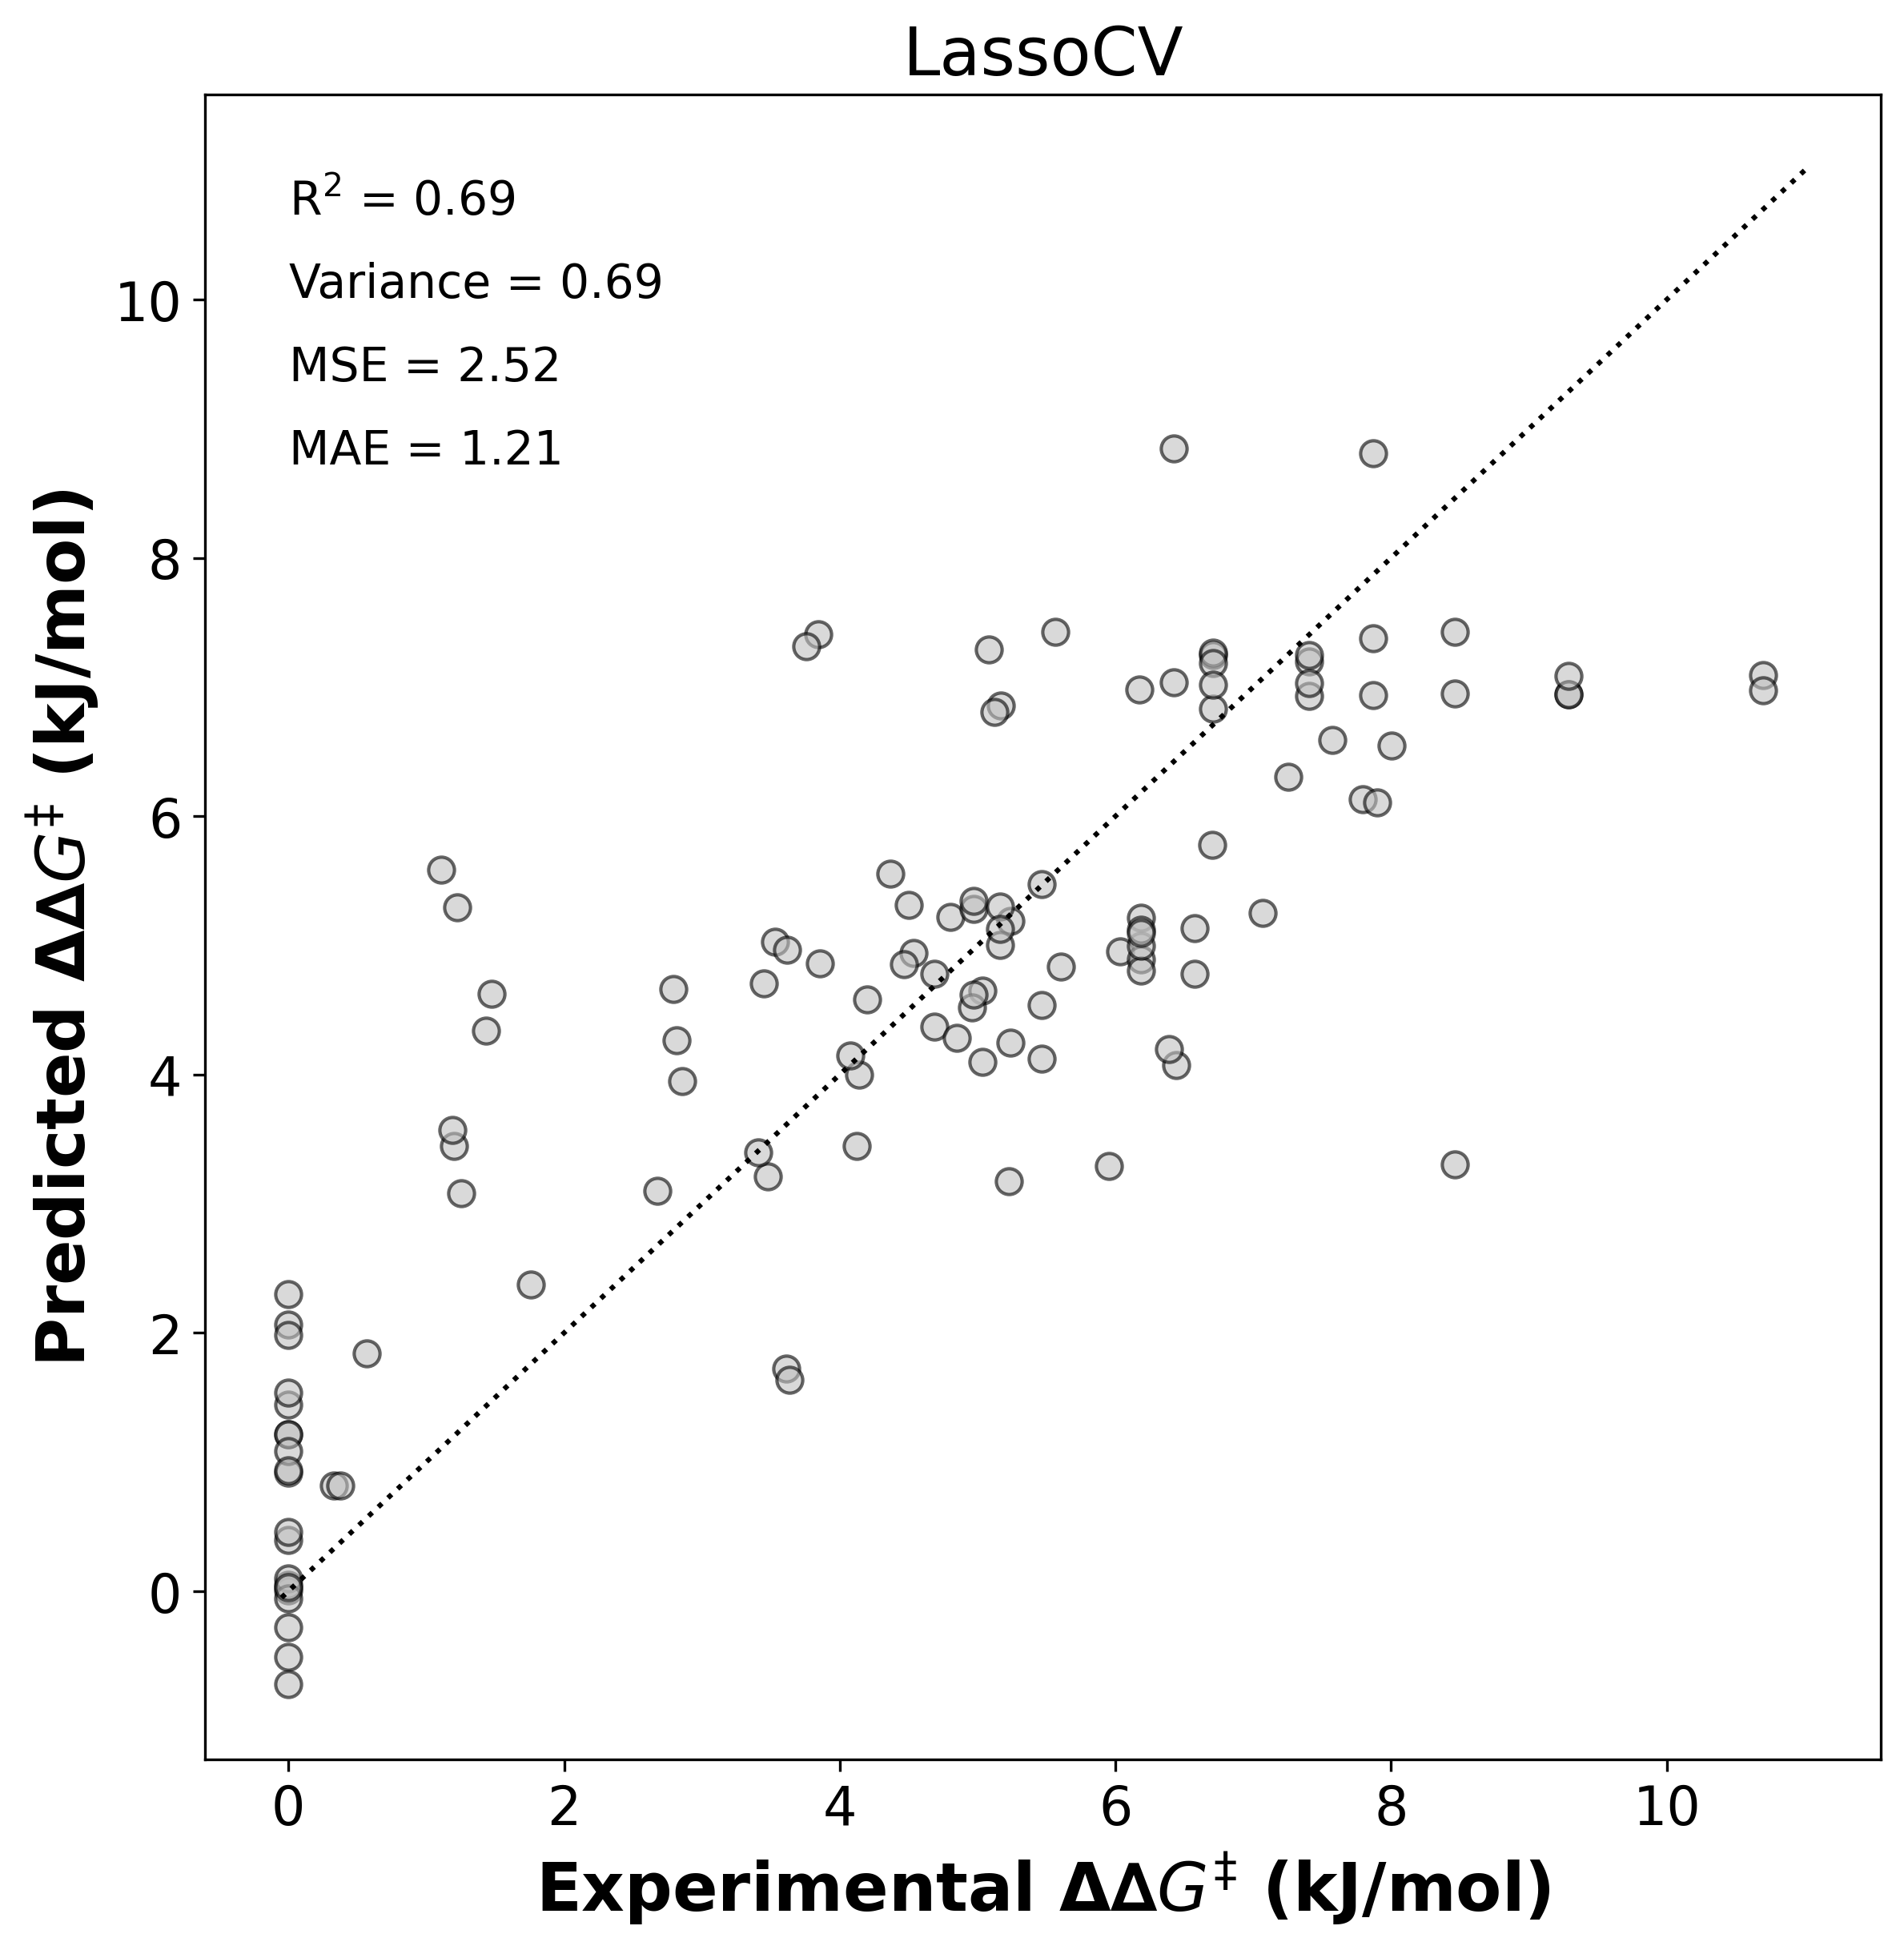

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

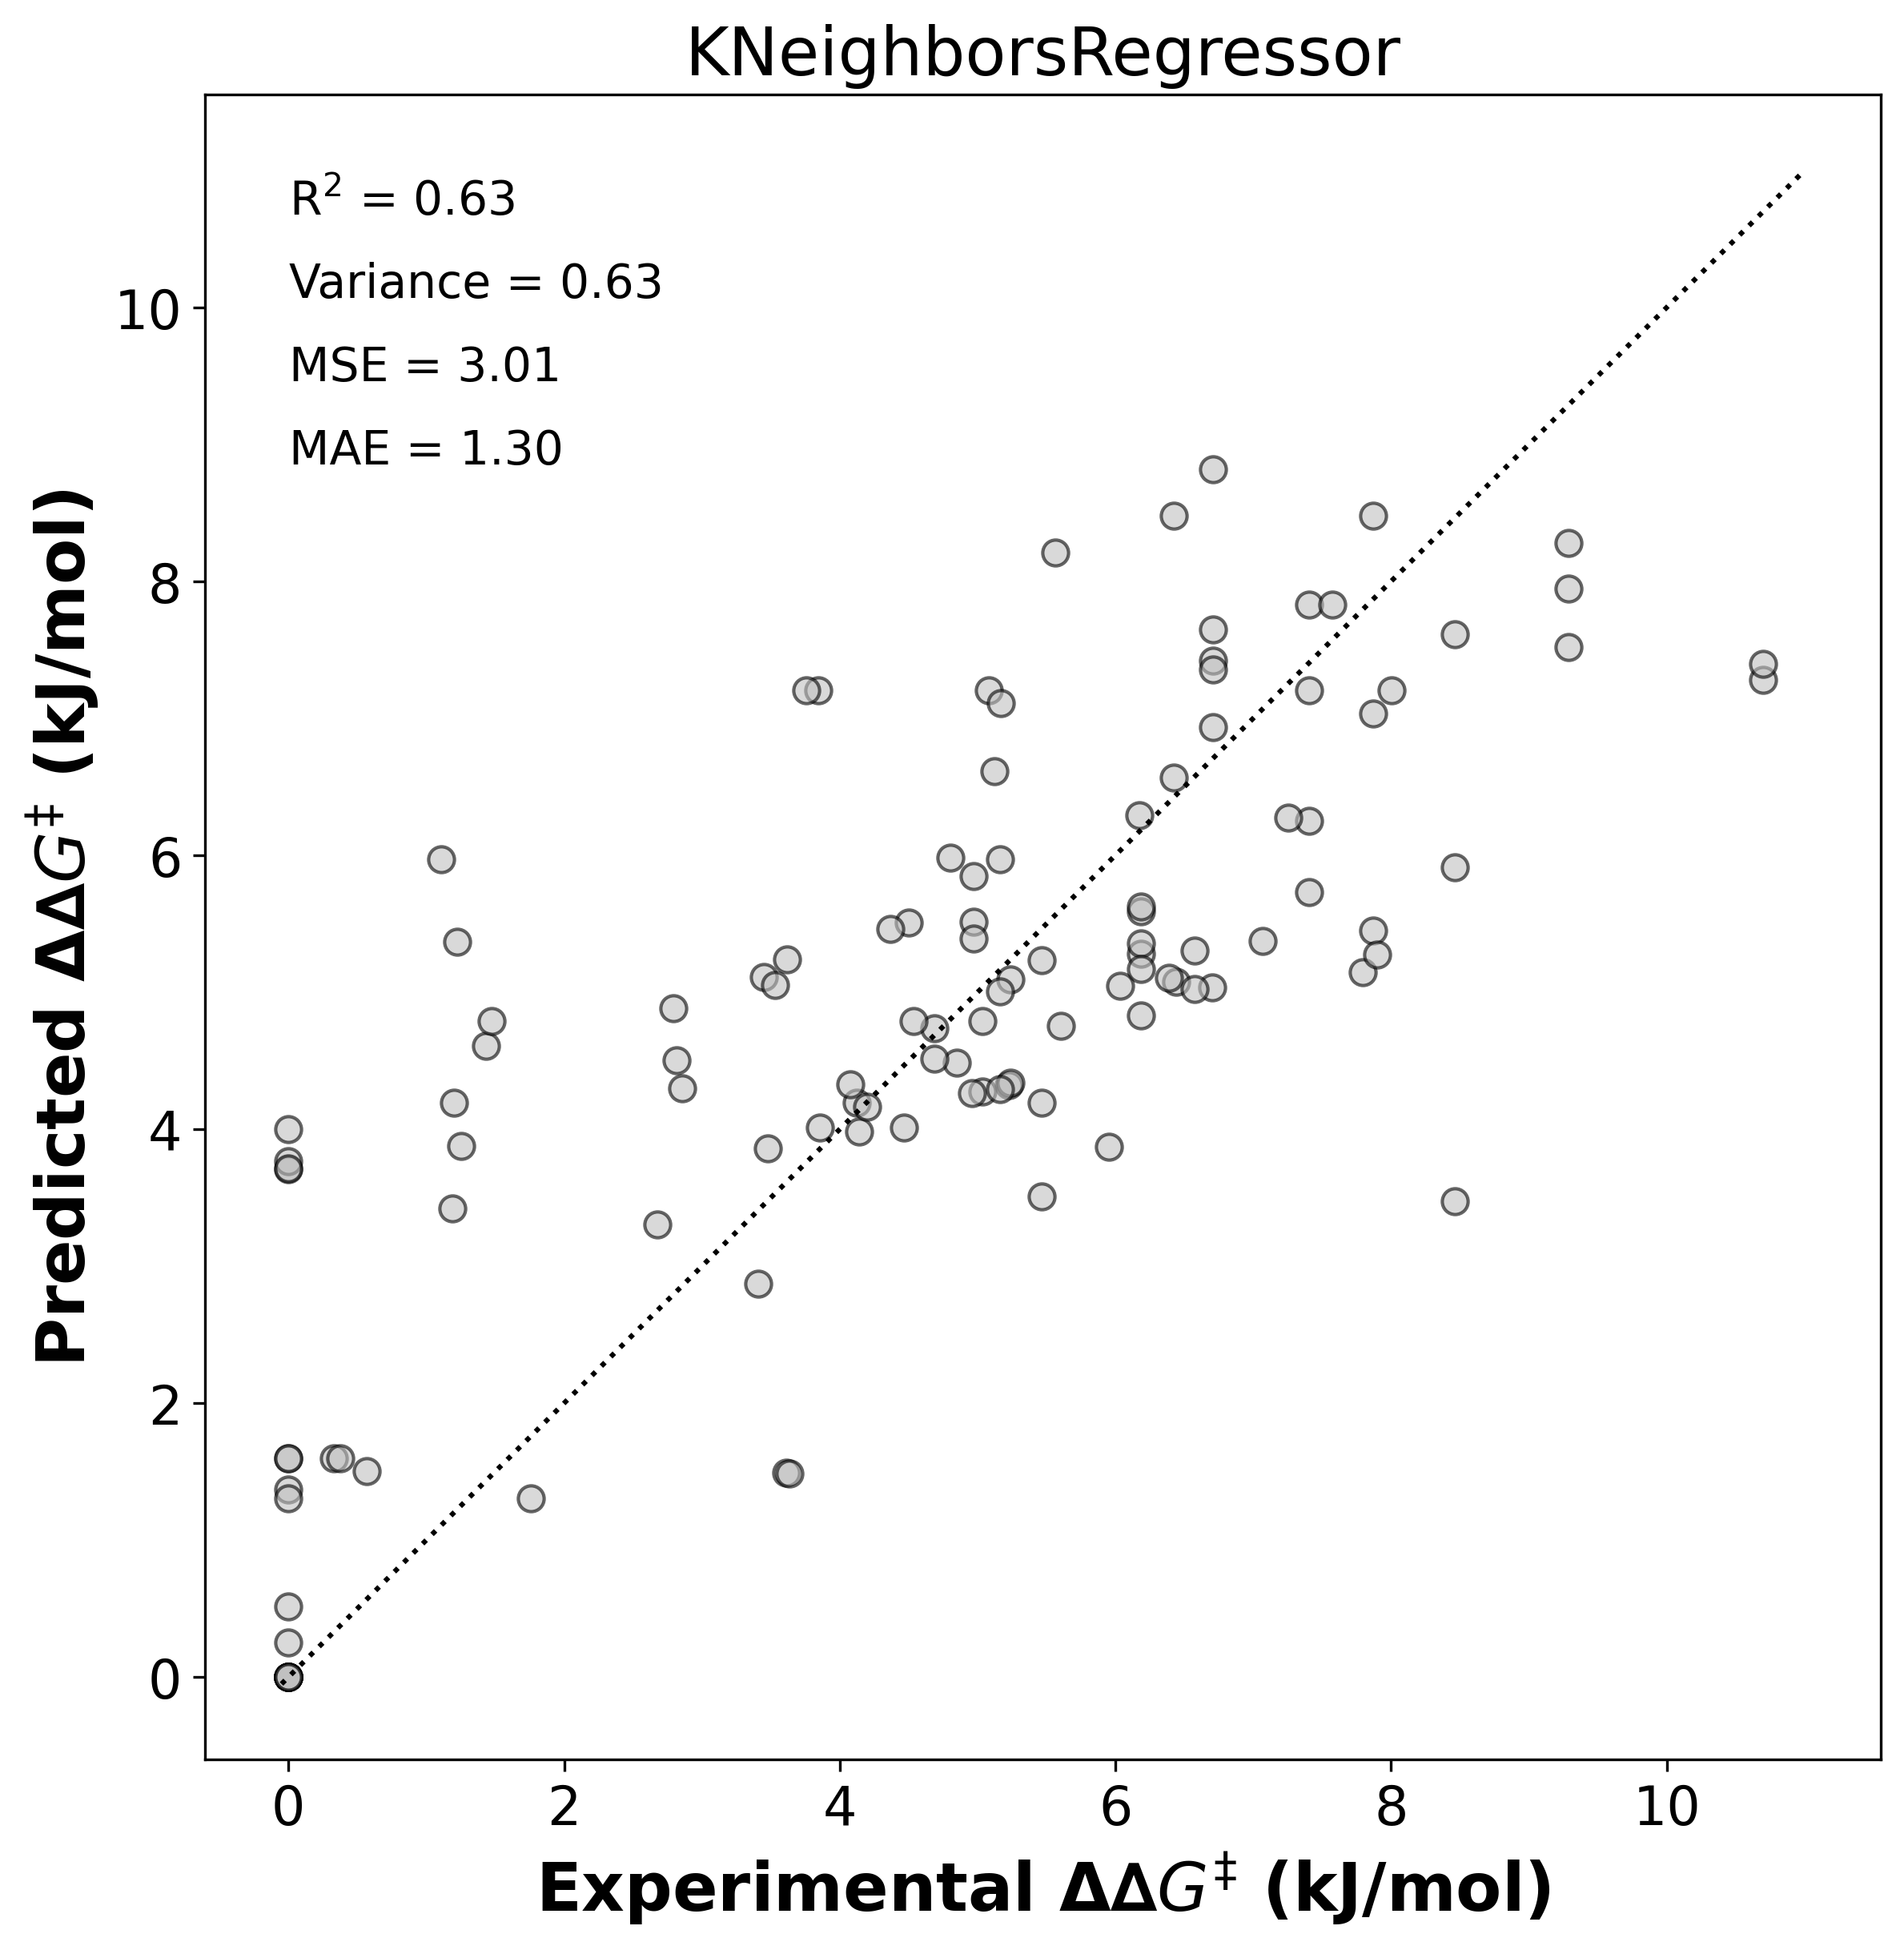

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

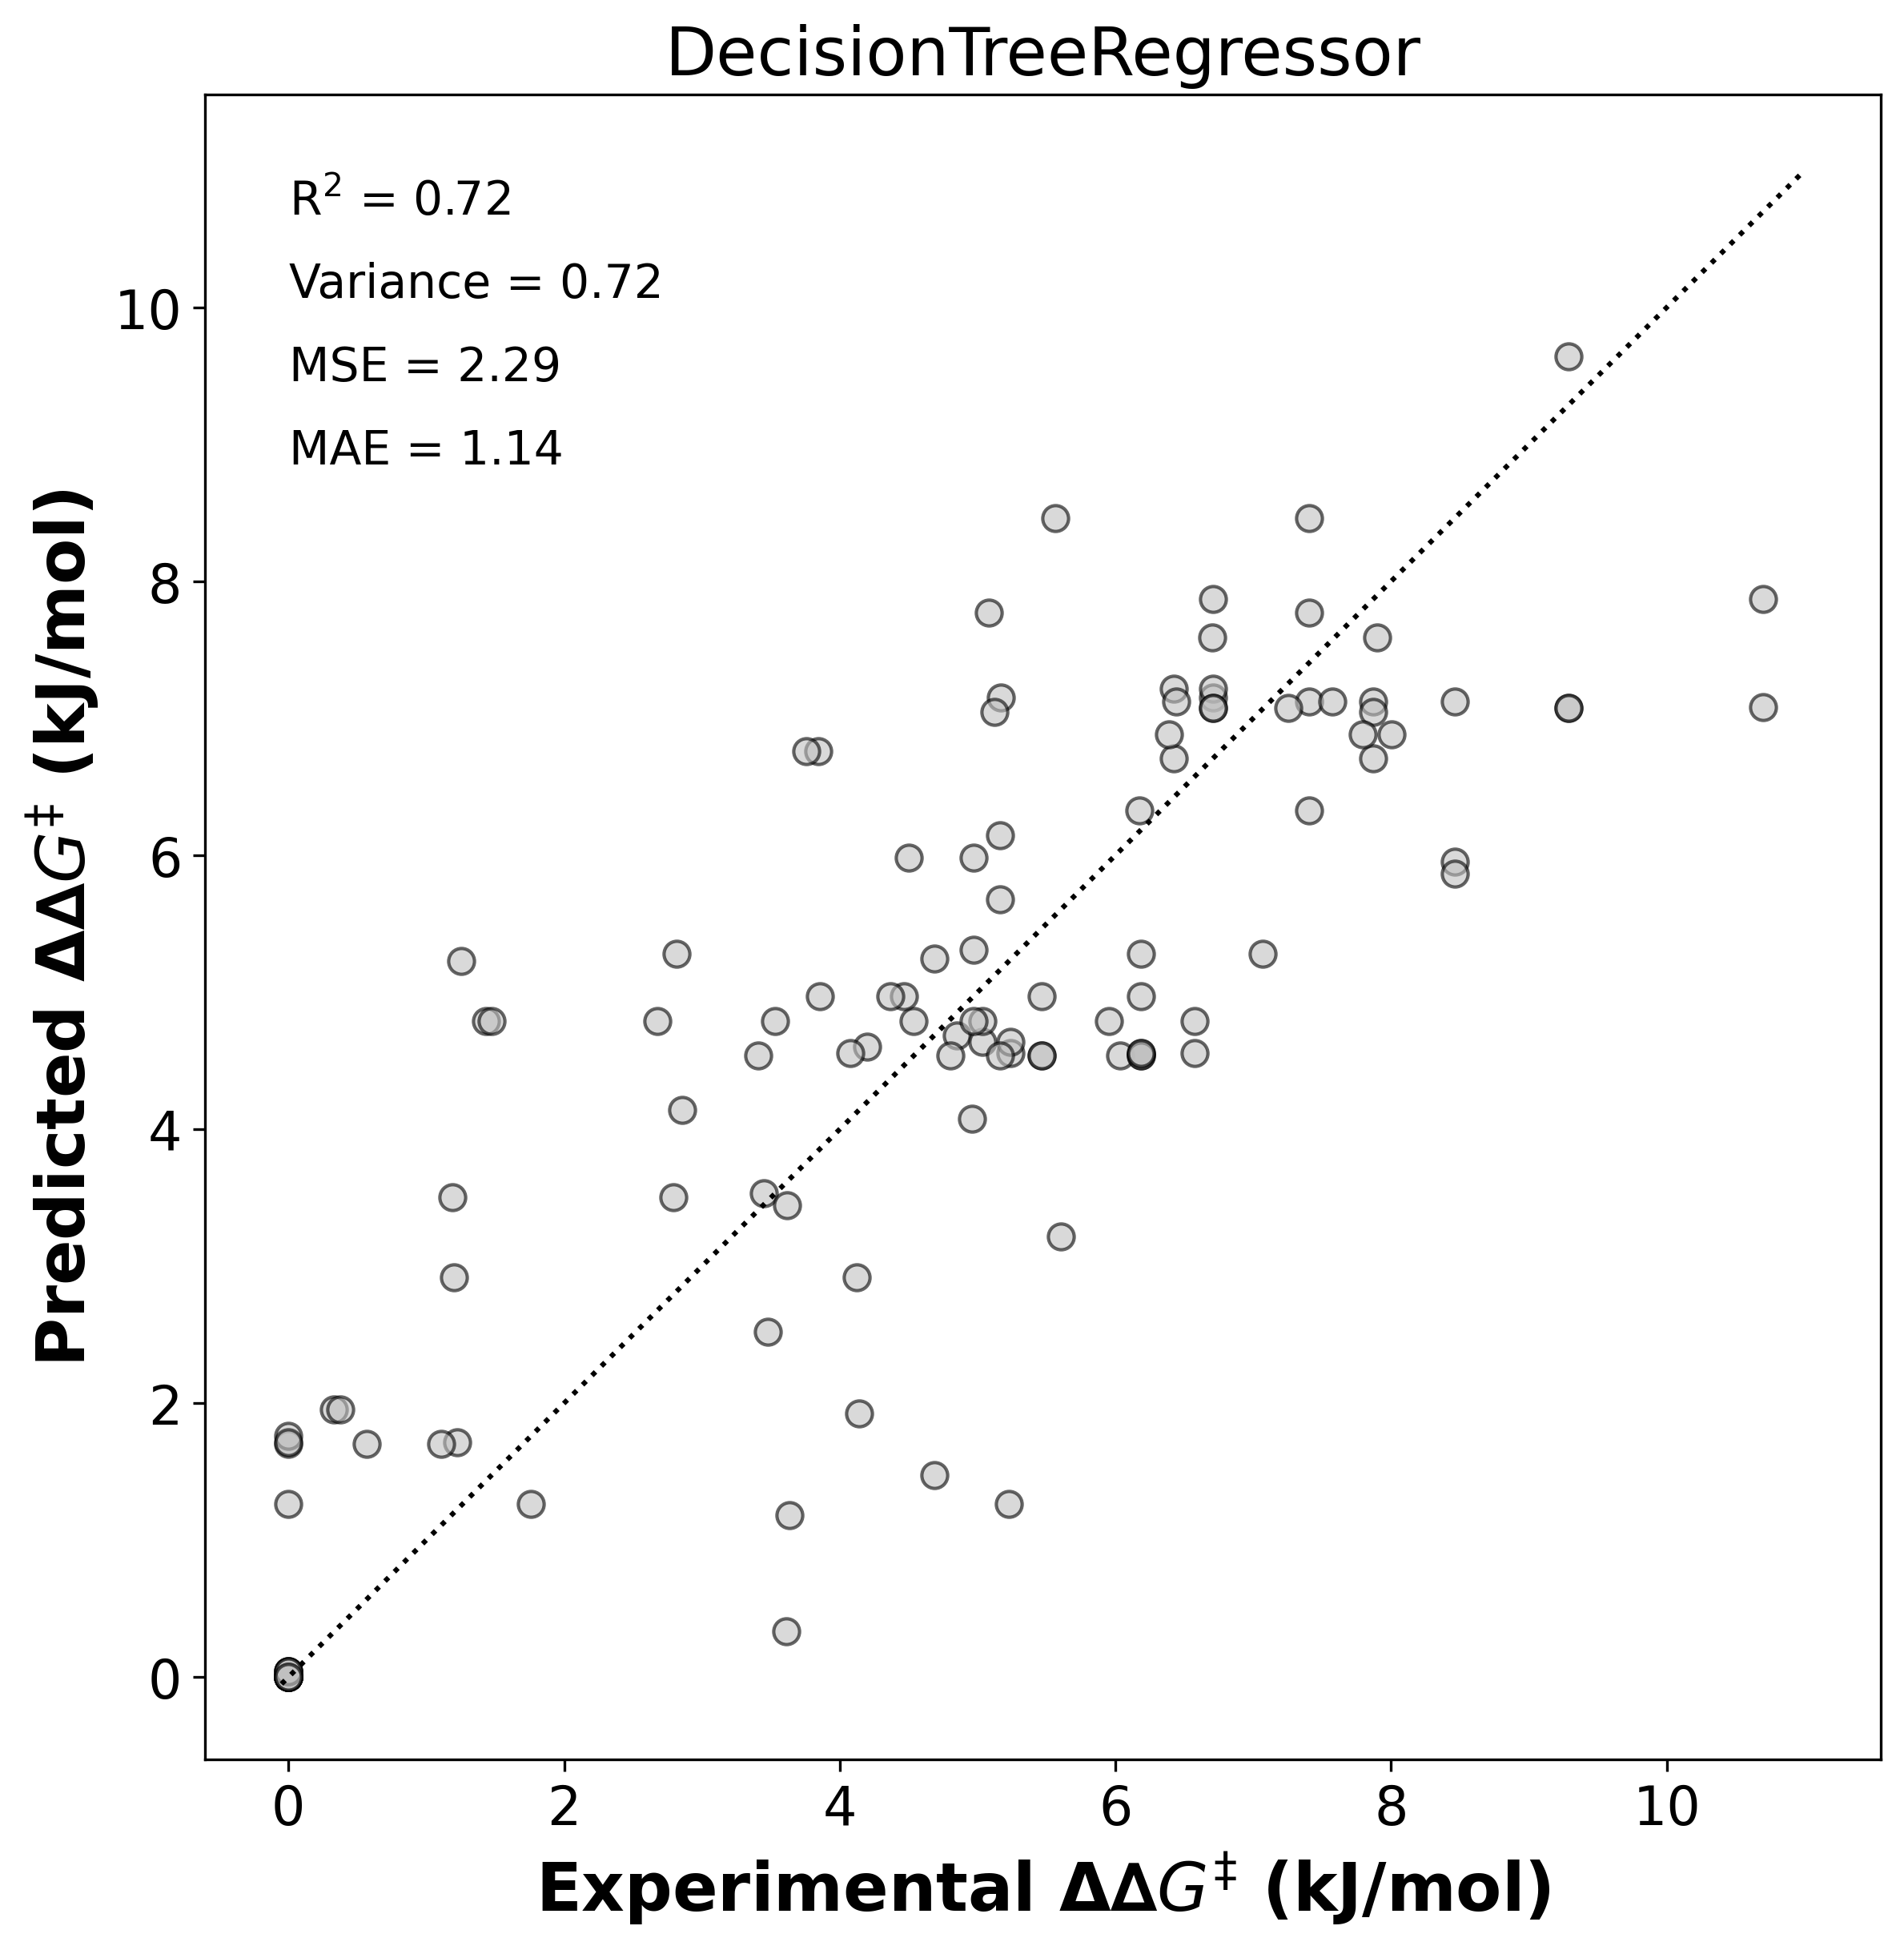

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

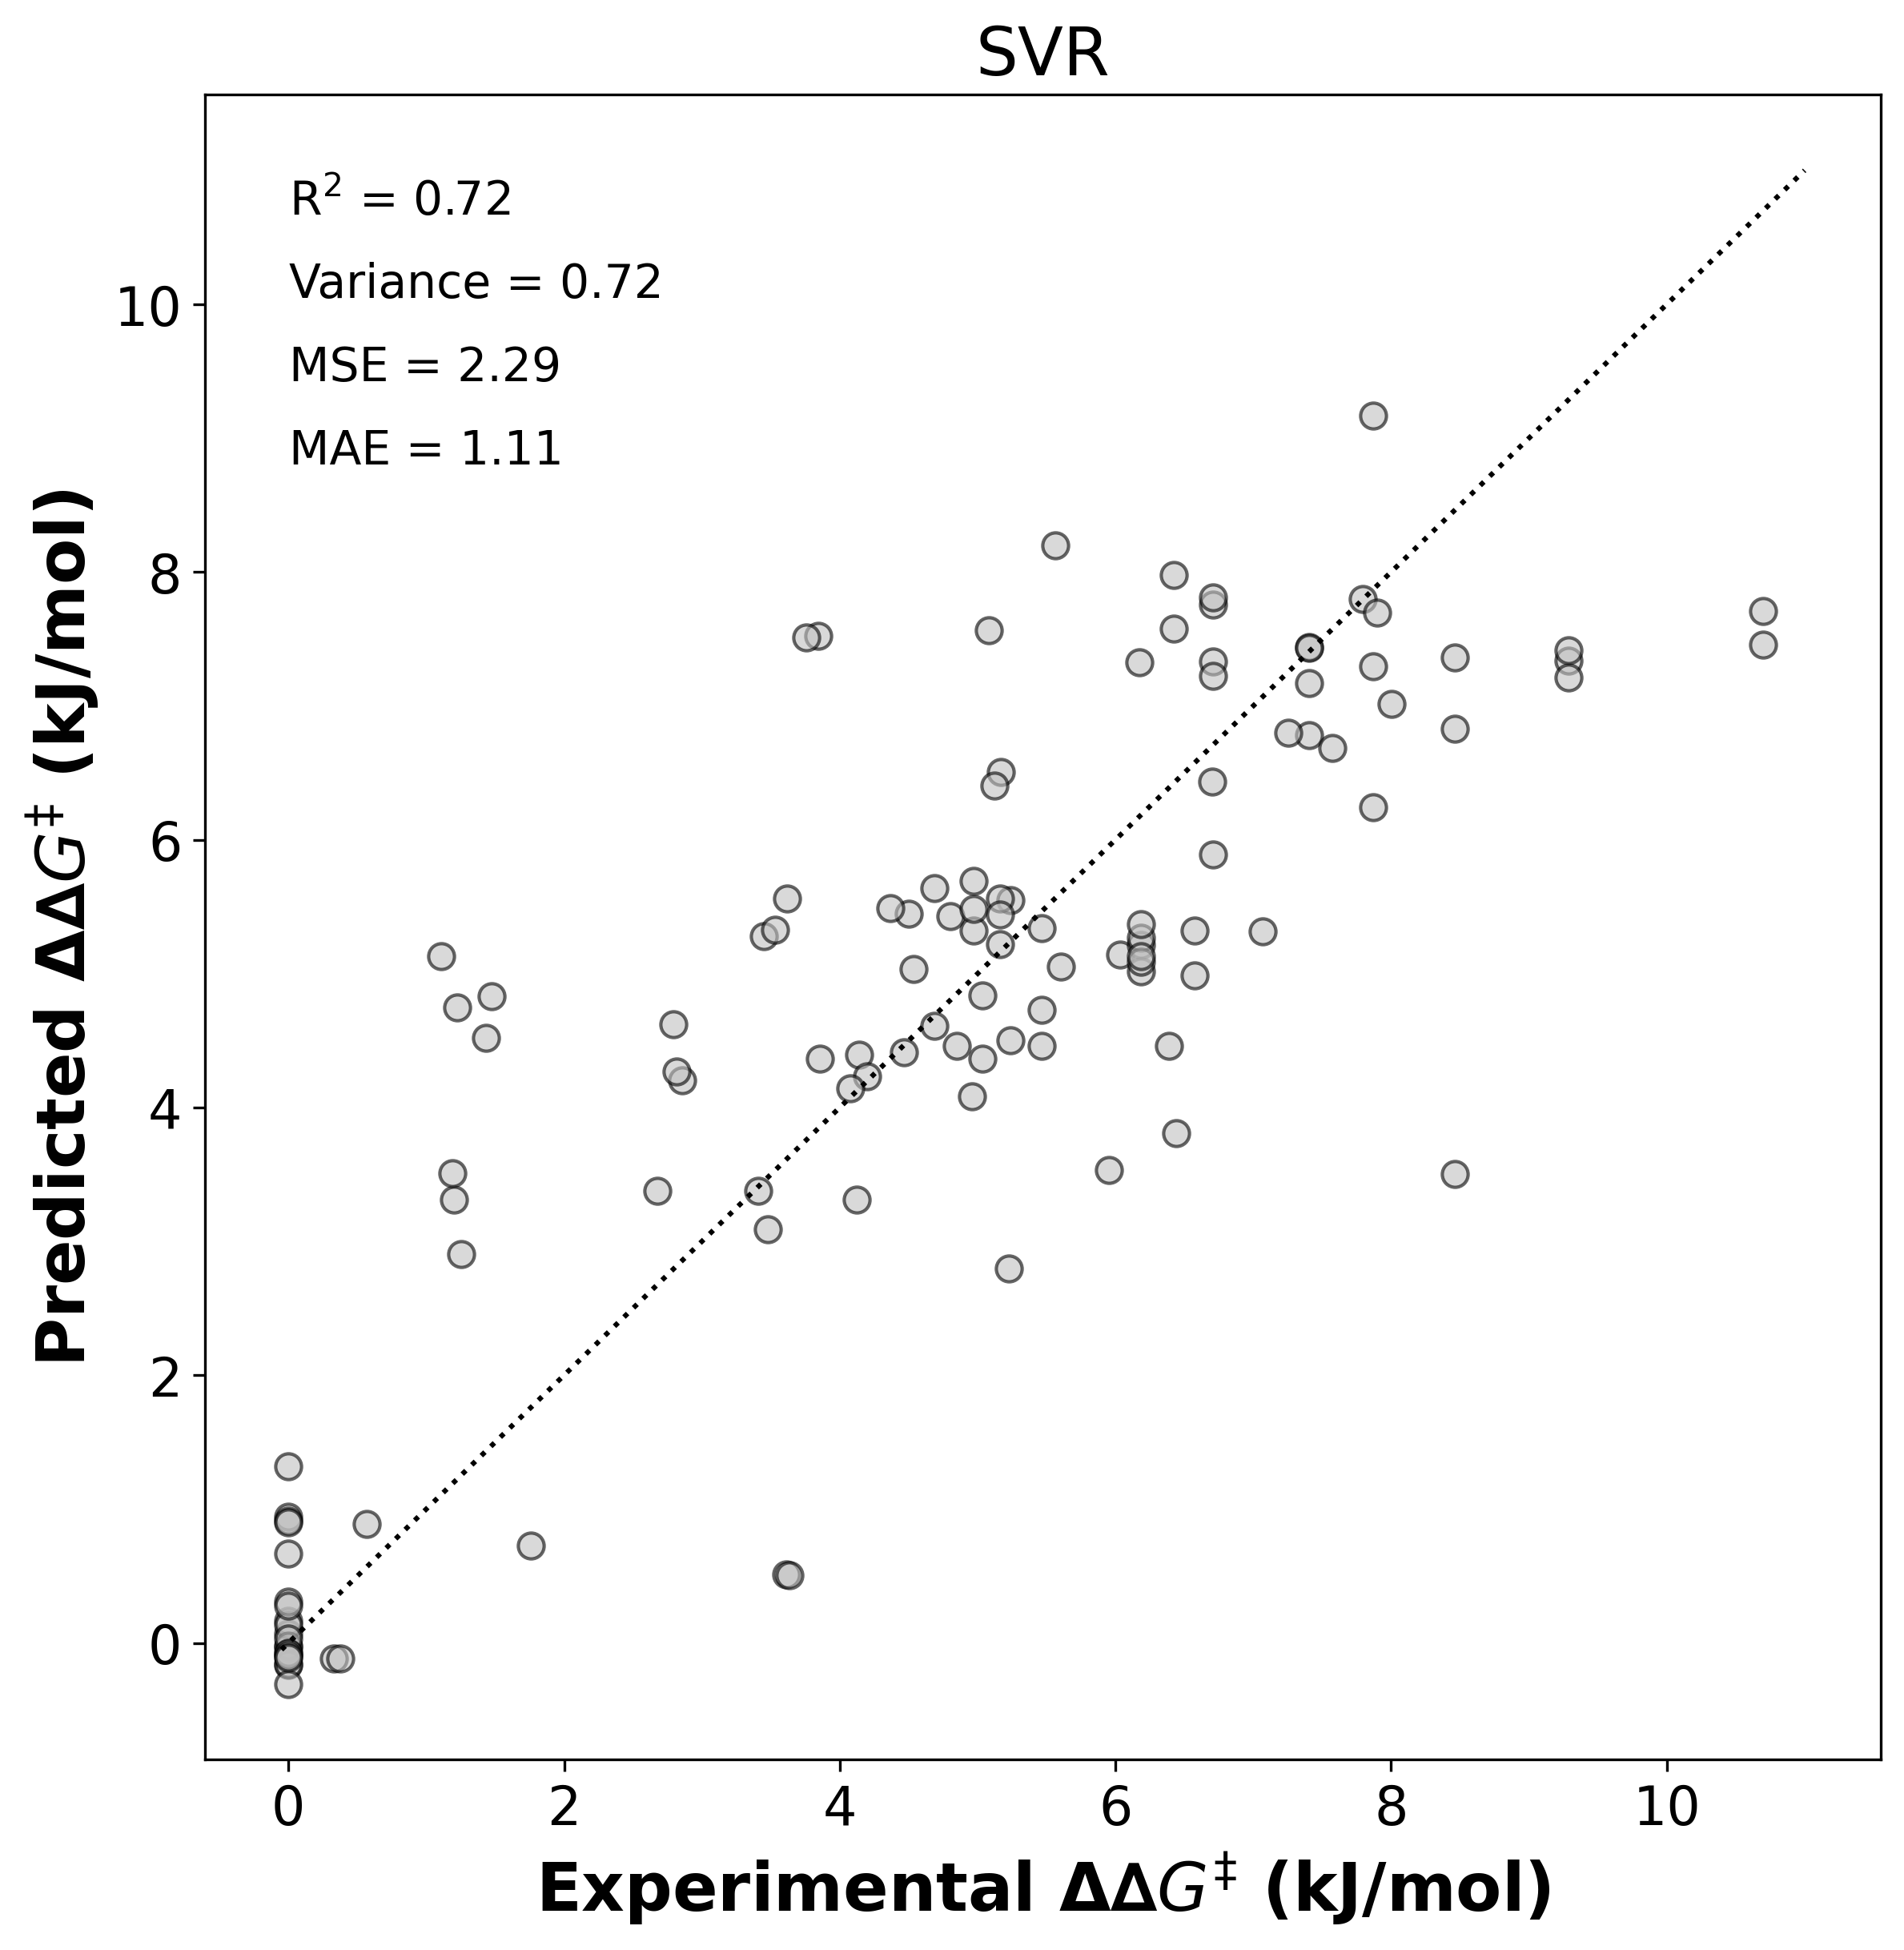

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

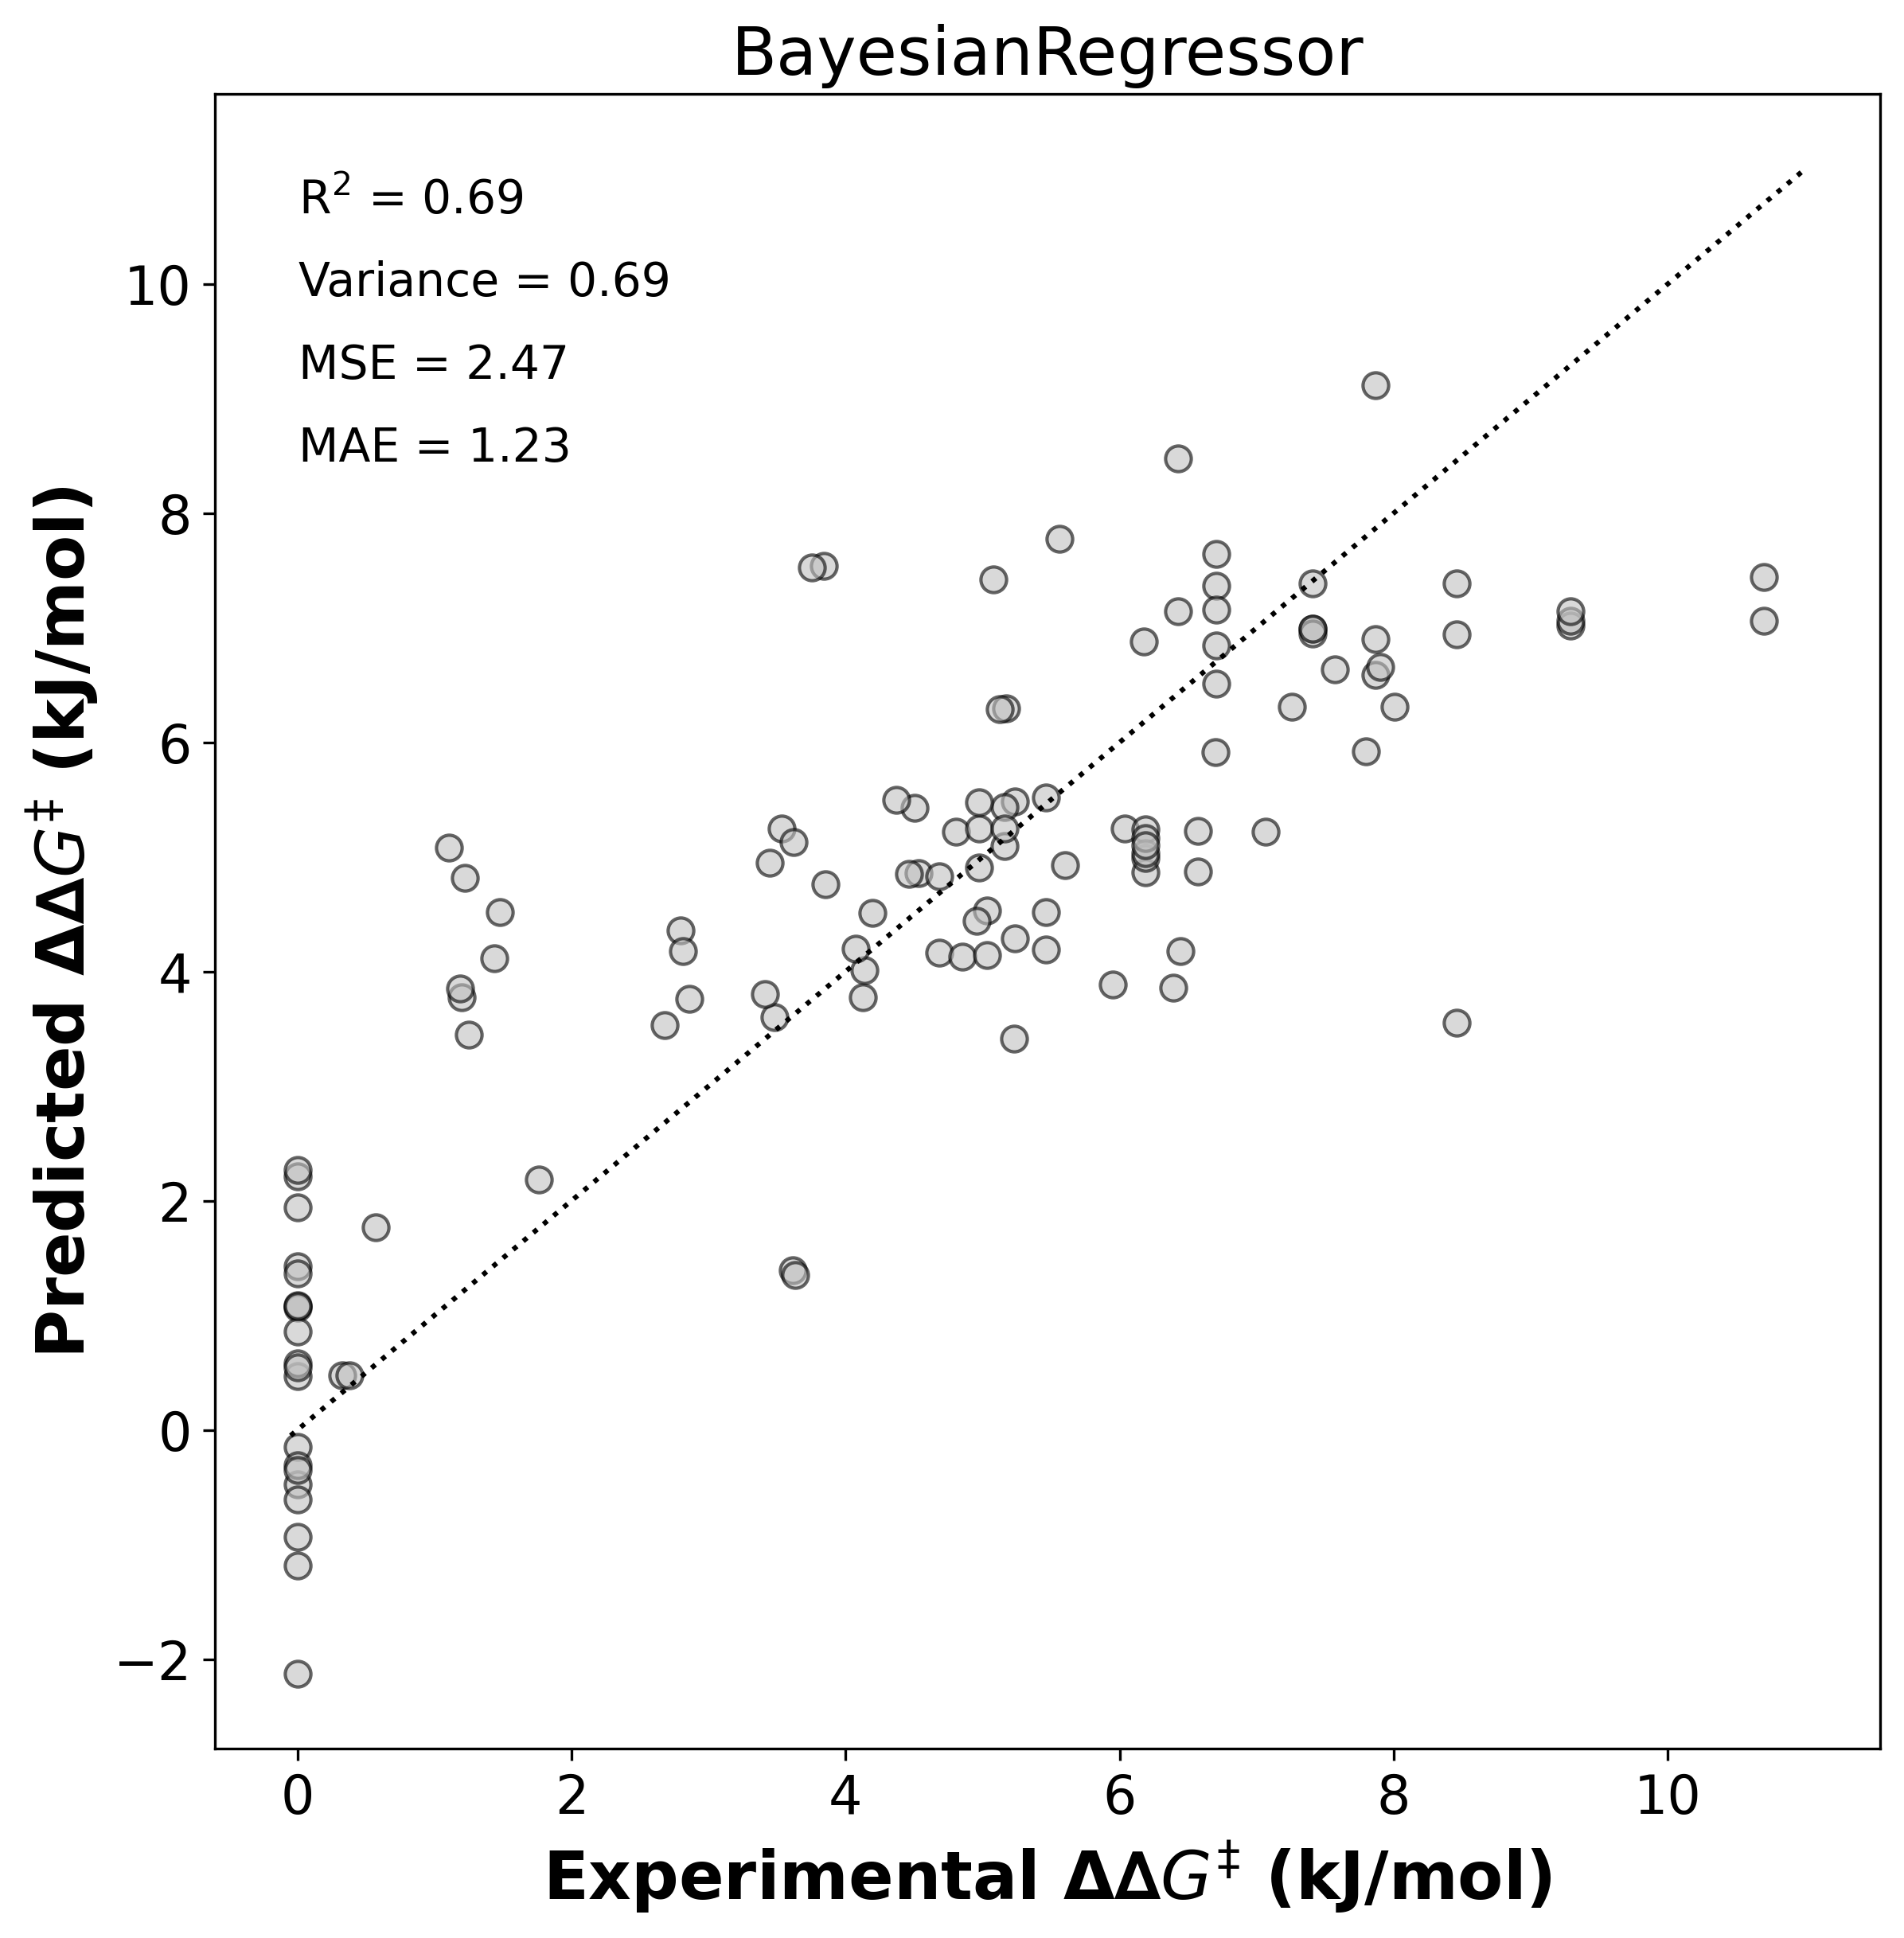

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

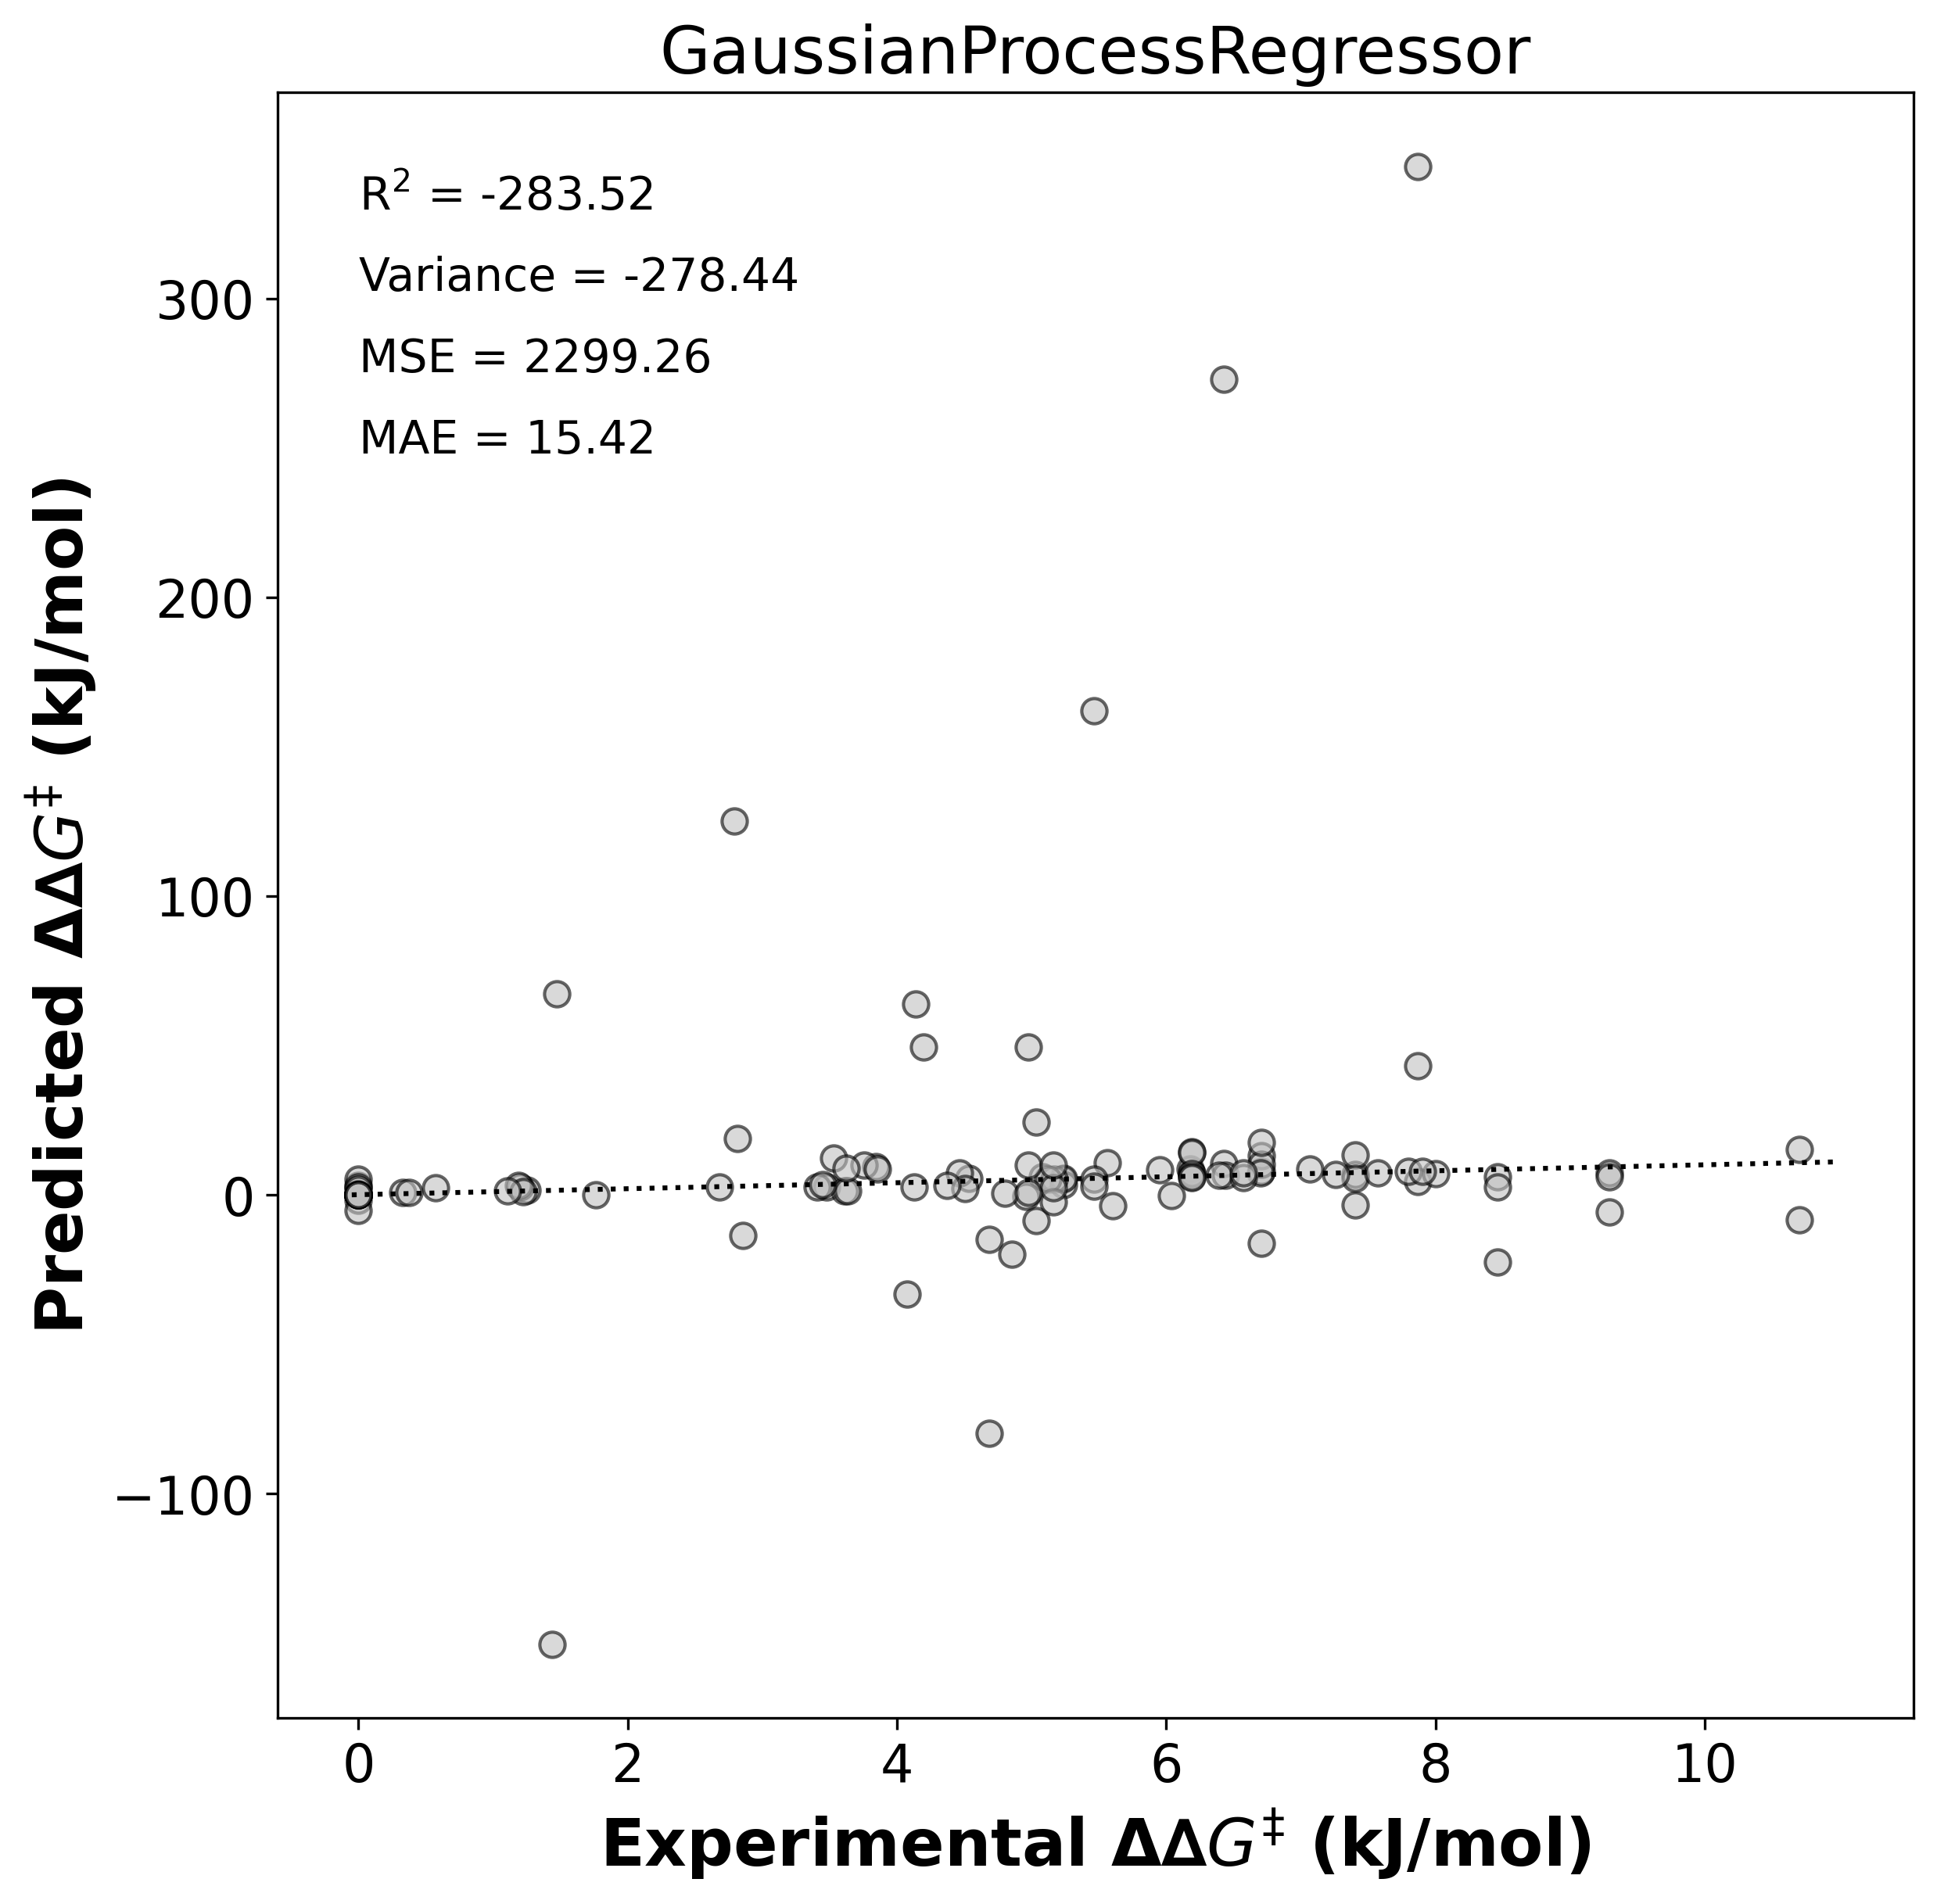

In [72]:
wf.metrics_for_regression(directories=directory_names)

# Now first we split 90%-10% (train-test)

We need to evaluate the performace of our model on an external test set. If you are not familiar with the process please read the paper section where this is explained.


In [115]:
data = pd.read_csv("../first_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

We know which data points we are using for test set, for consistency reasons. However if you have much more data and you dont know which ones you want to use as a training set, or you don't want to write them manually you could do something like this:

import pandas as pd

from sklearn.model_selection import train_test_split

df = pd.DataFrame(data)

X = df.drop('target', axis=1) y = df['target']

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print("X_test:") print(X_test)

print("y_test:") print(y_test)

In [116]:
test_reactions = [21, 81, 11, 104, 44, 106, 54, 95, 115, 25, 57, 52]

In [117]:
reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64


In [118]:
train_data = data.drop(labels =test_reactions, axis=0,inplace = False)

In [119]:
test_data = pd.DataFrame()
test_data = data.iloc[test_reactions]

In [120]:
substratesmiles_train = train_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_train.head()))

catalystsmiles_train = train_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_train.head()))

temp_train = train_data["temperature"]
log.info("DGG: {}".format(temp_train.head()))

ddg_train = train_data["ddg"]
log.info("DGG: {}".format(ddg_train.head()))

Substrate SMILES: 0         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
1    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
2         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
3    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
4         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
Name: substrate, dtype: object
Catalyst SMILES: 0    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
1    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
2    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
3    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
4    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
Name: catalyst, dtype: object
DGG: 0   -30.0
1   -30.0
2   -30.0
3   -30.0
4   -30.0
Name: temperature, dtype: float64
DGG: 0    0.569810
1    1.761325
2    1.251493
3    5.229434
4    2.678563
Name: ddg, dtype: float64


In [121]:
target_train = ddg_train

In [122]:
substratesmiles_test = test_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_test.head()))

catalystsmiles_test = test_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_test.head()))

temp_test = train_data["temperature"]
log.info("DGG: {}".format(temp_test.head()))

ddg_test = test_data["ddg"]
log.info("DGG: {}".format(ddg_test.head()))

Substrate SMILES: 21     COC(C=CC=C1)=C1/C=N/C(C2=CC=CC=C2)C3=CC=CC=C3
81                          C=CC/N=C/C1=C(OC)C=CC=C1
11         CC1(CCCCC1)/C=N/C(C2=CC=CC=C2)C3=CC=CC=C3
104      C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
44               C/C(C1=CC=CC=C1)=N\CC2=CC=C(OC)C=C2
Name: substrate, dtype: object
Catalyst SMILES: 21     CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
81     O=C([C@H](C(C)(C)C)NC(N[C@@H]1[C@@H](/N=C/C2=C...
11     CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
104    S=C(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)N[C@H]2[C...
44     O=C([C@@H](C(C)(C)C)NC(N[C@@H]1[C@@H](/N=C/C2=...
Name: catalyst, dtype: object
DGG: 0   -30.0
1   -30.0
2   -30.0
3   -30.0
4   -30.0
Name: temperature, dtype: float64
DGG: 21     5.562698
81     3.446852
11     7.406515
104    0.000000
44     5.464455
Name: ddg, dtype: float64


In [123]:
target_test = ddg_test

Mordred for substrates trainset

In [124]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list_train = [ms.get_mol_from_smiles(s) for s in substratesmiles_train]
subfeatures_df_train = calc.pandas(submolecule_list_train)

100%|█████████████████████████████████████████| 107/107 [00:07<00:00, 14.50it/s]


In [125]:
subfeatures_df_train.dropna(inplace=True, thresh=int(0.9*len(subfeatures_df_train.index)))
threshold = 0.5
subfeatures_df_train.drop(subfeatures_df_train.std()[subfeatures_df_train.std() < threshold].index.values, axis=1)
subfeatures_df_train.columns = [ent.strip() for ent in subfeatures_df_train.columns]
subfeatures_df_train.head()

/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_33551/989884597.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  subfeatures_df_train.drop(subfeatures_df_train.std()[subfeatures_df_train.std() < threshold].index.values, axis=1)


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,14.538011,12.482550,0,0,23.734067,2.345955,4.691910,23.734067,1.249161,3.853399,...,9.625162,51.858564,251.1674,6.279185,706,24,94.0,104.0,6.395833,4.180556
1,16.182576,12.923224,0,0,28.376768,2.343528,4.687055,28.376768,1.351275,3.966671,...,9.687009,54.282362,271.1361,7.135161,958,28,104.0,118.0,4.694444,4.805556
2,14.538011,12.482550,0,0,23.734067,2.345955,4.691910,23.734067,1.249161,3.853399,...,9.625162,51.858564,251.1674,6.279185,706,24,94.0,104.0,6.395833,4.180556
3,16.182576,12.923224,0,0,28.376768,2.343528,4.687055,28.376768,1.351275,3.966671,...,9.687009,54.282362,271.1361,7.135161,958,28,104.0,118.0,4.694444,4.805556
4,14.538011,12.482550,0,0,23.734067,2.345955,4.691910,23.734067,1.249161,3.853399,...,9.625162,51.858564,251.1674,6.279185,706,24,94.0,104.0,6.395833,4.180556


Mordredfor catalysts

In [126]:
calc = Calculator(descriptors, ignore_3D=False)
catmolecule_list_train = [ms.get_mol_from_smiles(s) for s in catalystsmiles_train]
catfeatures_df_train = calc.pandas(catmolecule_list_train)

100%|█████████████████████████████████████████| 107/107 [00:18<00:00,  5.84it/s]


In [127]:
catfeatures_df_train.dropna(inplace=True, thresh=int(0.9*len(catfeatures_df_train.index)))
threshold = 0.5
catfeatures_df_train.drop(catfeatures_df_train.std()[catfeatures_df_train.std() < threshold].index.values, axis=1)
catfeatures_df_train.columns = [ent.strip() for ent in catfeatures_df_train.columns]
catfeatures_df_train.head()

/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_33551/2726301395.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  catfeatures_df_train.drop(catfeatures_df_train.std()[catfeatures_df_train.std() < threshold].index.values, axis=1)


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,21.401108,19.292802,0,0,30.867985,2.425439,4.850878,30.867985,1.102428,4.224506,...,10.282506,63.404103,429.130953,8.757775,2068,43,144.0,162.0,15.215278,5.722222
1,21.401108,19.292802,0,0,30.867985,2.425439,4.850878,30.867985,1.102428,4.224506,...,10.282506,63.404103,429.130953,8.757775,2068,43,144.0,162.0,15.215278,5.722222
2,26.241465,22.162609,0,0,39.436111,2.426470,4.852941,39.436111,1.159886,4.427881,...,10.440303,70.325912,505.162253,8.562072,3643,52,176.0,199.0,15.826389,7.055556
3,26.241465,22.162609,0,0,39.436111,2.426470,4.852941,39.436111,1.159886,4.427881,...,10.440303,70.325912,505.162253,8.562072,3643,52,176.0,199.0,15.826389,7.055556
4,26.977082,23.080194,0,0,40.925850,2.428813,4.857626,40.925850,1.169310,4.457444,...,10.507612,71.558608,519.177903,8.373837,3880,56,182.0,208.0,16.687500,7.277778


Pearsons

In [128]:
subreasonable_predicted_properties, subsignificant_features = wf.find_correlating_features(subfeatures_df_train, target_train, thresh=0.36, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0      0.569810
1      1.761325
2      1.251493
3      5.229434
4      2.678563
         ...   
113    0.000000
114    0.000000
116    0.000000
117    0.000000
118    0.000000
Name: ddg, Length: 107, dtype: float64
Significance will be calculated for the correlations
GATS3c: -0.4470 P: 0.0002 Significant at 0.0500 level? True
GATS3se: -0.4752 P: 0.0002 Significant at 0.0500 level? True
GATS3pe: -0.4085 P: 0.0002 Significant at 0.0500 level? True
GATS3are: -0.4365 P: 0.0002 Significant at 0.0500 level? True
Lipinski: -0.3801 P: 0.0002 Significant at 0.0500 level? True
GGI9: 0.3833 P: 0.0002 Significant at 0.0500 level? True


In [129]:
log.info("{} {}".format(subreasonable_predicted_properties, len(subreasonable_predicted_properties)))
log.info("{} {}".format(subsignificant_features, len(subsignificant_features)))
use_significant = True
use_reasonable = False

['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski', 'GGI9'] 6
['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski', 'GGI9'] 6


In [130]:
catreasonable_predicted_properties, catsignificant_features = wf.find_correlating_features(catfeatures_df_train, target_train, thresh=0.55, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0      0.569810
1      1.761325
2      1.251493
3      5.229434
4      2.678563
         ...   
113    0.000000
114    0.000000
116    0.000000
117    0.000000
118    0.000000
Name: ddg, Length: 107, dtype: float64
Significance will be calculated for the correlations
VE3_A: 0.5949 P: 0.0002 Significant at 0.0500 level? True
ATS5Z: 0.6073 P: 0.0002 Significant at 0.0500 level? True
ATS5m: 0.5637 P: 0.0002 Significant at 0.0500 level? True
ATS5v: 0.6028 P: 0.0002 Significant at 0.0500 level? True
ATS6v: 0.6053 P: 0.0002 Significant at 0.0500 level? True
ATS6se: 0.6276 P: 0.0002 Significant at 0.0500 level? True
ATS7se: 0.5807 P: 0.0002 Significant at 0.0500 level? True
ATS6pe: 0.6284 P: 0.0002 Significant at 0.0500 level? True
ATS7pe: 0.5761 P: 0.0002 Significant at 0.0500 level? True
ATS6are: 0.6272 P: 0.0002 Significant at 0.0500 level? True
ATS7are: 0.5759 P: 0.0002 Significant at 0.0500 level? True
ATS5p: 0.5862 P: 0.0002 Significant at 0.0500 level? True
ATS6p: 0.6165 P: 0.0002 Sign

In [131]:
log.info("{} {}".format(catreasonable_predicted_properties, len(catreasonable_predicted_properties)))
log.info("{} {}".format(catsignificant_features, len(catsignificant_features)))
use_significant = True
use_reasonable = False

['VE3_A', 'ATS5Z', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS6se', 'ATS7se', 'ATS6pe', 'ATS7pe', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i', 'ATS7i', 'AATS8i', 'ATSC3se', 'ATSC3pe', 'ATSC3are', 'AATSC0c', 'AATSC6c', 'MATS1are', 'Xpc-6dv', 'MAXaaCH', 'MAXaasC', 'PEOE_VSA6', 'MDEC-22', 'GGI3', 'GGI6', 'GGI8'] 31
['VE3_A', 'ATS5Z', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS6se', 'ATS7se', 'ATS6pe', 'ATS7pe', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i', 'ATS7i', 'AATS8i', 'ATSC3se', 'ATSC3pe', 'ATSC3are', 'AATSC0c', 'AATSC6c', 'MATS1are', 'Xpc-6dv', 'MAXaaCH', 'MAXaasC', 'PEOE_VSA6', 'MDEC-22', 'GGI3', 'GGI6', 'GGI8'] 31


In [132]:
subfeats_df_train = pd.DataFrame()

if use_significant is True:
    for k in subsignificant_features:
        subfeats_df_train[k] = subfeatures_df_train[k]
        
elif use_reasonable is True:
    for k in subreasonable_predicted_properties:
        subfeats_df_train[k] = subfeatures_df_train[k]

In [133]:
catfeats_df_train = pd.DataFrame()

if use_significant is True:
    for k in catsignificant_features:
        catfeats_df_train[k] = catfeatures_df_train[k]
        
elif use_reasonable is True:
    for k in catreasonable_predicted_properties:
        catfeats_df_train[k] = catfeatures_df_train[k]

In [134]:
features_df_train = subfeats_df_train.join(catfeats_df_train, lsuffix="subfeats_df_train", rsuffix="catfeats_df_train")

In [135]:
features_df_train = features_df_train.join(temp_train.reset_index(drop=True))

In [136]:
features_df_train.to_csv('features_train.csv')

Test set

In [137]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list_test = [ms.get_mol_from_smiles(s) for s in substratesmiles_test]
subfeatures_df_test = calc.pandas(submolecule_list_test)

100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  6.43it/s]


In [138]:
calc = Calculator(descriptors, ignore_3D=False)
catmolecule_list_test = [ms.get_mol_from_smiles(s) for s in catalystsmiles_test]
catfeatures_df_test = calc.pandas(catmolecule_list_test)

100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.13it/s]


In [139]:
testfeats_df_sub = pd.DataFrame()
testcontinous_features = []
testcatagorical_features = []

# Make sure features cover all the molecules, if not don't use them as we will loose data points doing this
n_features = len(ddg_train)

# Add Mordred descriptors
for ent in subreasonable_predicted_properties:
#     tmp = testfeatures_df[ent].copy()
#     tmp.dropna(inplace=True)
#     if len(tmp.values) == n_features:
    testfeats_df_sub[ent] = subfeatures_df_test[ent].values 
#     print(testfeats_df[ent])
    testcontinous_features.append(ent)
#     else:
#         log.warning("Dropping feature because it is not avaliable for all molecules")
#     del tmp
print(testfeats_df_sub)

      GATS3c   GATS3se   GATS3pe  GATS3are  Lipinski      GGI9
0   0.958146  0.950708  0.917143  0.928732      True  0.096250
1   1.019501  1.067694  0.981975  1.009922      True  0.000000
2   0.953450  1.030349  1.019503  1.015825     False  0.045000
3   0.981164  1.031415  0.978073  0.989808      True  0.045000
4   1.079664  1.193379  1.181657  1.201571      True  0.062500
..       ...       ...       ...       ...       ...       ...
7   0.983640  1.056407  1.070055  1.058030      True  0.000000
8   1.101164  1.187627  1.169919  1.166806      True  0.000000
9   0.751475  0.692028  0.804199  0.770557      True  0.013117
10  1.101164  1.187627  1.169919  1.166806      True  0.000000
11  1.101164  1.187627  1.169919  1.166806      True  0.000000

[12 rows x 6 columns]


In [140]:
testfeats_df_cat = pd.DataFrame()
testcontinous_features = []
testcatagorical_features = []

# Make sure features cover all the molecules if not don't use them as we will loose data points doing this
n_features = len(ddg_train)

# Add Mordred descriptors
for ent in catreasonable_predicted_properties:
#     tmp = testfeatures_df[ent].copy()
#     tmp.dropna(inplace=True)
#     if len(tmp.values) == n_features:
    testfeats_df_cat[ent] = catfeatures_df_test[ent].values 
#     print(testfeats_df[ent])
    testcontinous_features.append(ent)
#     else:
#         log.warning("Dropping feature because it is not avaliable for all molecules")
#     del tmp
print(testfeats_df_cat)

       VE3_A   ATS5Z         ATS5m         ATS5v         ATS6v       ATS6se  \
0   3.116852  4469.0  16828.947682  39537.363935  41046.436724  1830.262018   
1   3.011422  4315.0  15392.622928  43113.080733  44658.369232  1961.626346   
2   3.116852  4469.0  16828.947682  39537.363935  41046.436724  1830.262018   
3   2.549356  2644.0  10244.498446  18604.384302  16248.738971   805.900338   
4   3.011422  3875.0  13672.618316  41504.320794  43299.754273  1992.660968   
..       ...     ...           ...           ...           ...          ...   
7   3.011422  4315.0  15392.622928  43113.080733  44658.369232  1961.626346   
8   2.138716  1992.0   7945.773694  11967.479765  10656.801016   567.809490   
9   3.116852  4469.0  16828.947682  39537.363935  41046.436724  1830.262018   
10  2.856647  3734.0  13986.347236  31180.594742  30949.042524  1493.323210   
11  3.116852  4469.0  16828.947682  39537.363935  41046.436724  1830.262018   

         ATS7se     ATS6pe     ATS7pe   ATS6are  ..

In [141]:
features_df_test = testfeats_df_sub.join(testfeats_df_cat, lsuffix="subfeats_df", rsuffix="catfeats_df")

In [142]:
features_df_test = features_df_test.join(temp_test.reset_index(drop=True))

In [143]:
features_df_train,categorical_indxs = wf.feature_categorization(features_df_train, feature_types = "some_categorical")

-----
Categorical features not provided. Trying to guess the categorical features automatically.
-----
Automatically assigned categorical indices:
[4] 1
Automatically assigned categorical features:
['Lipinski'] 1
**Please check if the automatic assignment is correct. If not, please provide the indices of the categorical features.**
-----
Numerical features:
['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'GGI9', 'VE3_A', 'ATS5Z', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS6se', 'ATS7se', 'ATS6pe', 'ATS7pe', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i', 'ATS7i', 'AATS8i', 'ATSC3se', 'ATSC3pe', 'ATSC3are', 'AATSC0c', 'AATSC6c', 'MATS1are', 'Xpc-6dv', 'MAXaaCH', 'MAXaasC', 'PEOE_VSA6', 'MDEC-22', 'GGI3', 'GGI6', 'GGI8', 'temperature'] 37
Categorical features:
['Lipinski'] 1
Index(['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'GGI9', 'VE3_A', 'ATS5Z',
       'ATS5m', 'ATS5v', 'ATS6v', 'ATS6se', 'ATS7se', 'ATS6pe', 'ATS7pe',
       'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i', 'ATS7

In [144]:
features_df_test,categorical_indxs = wf.feature_categorization(features_df_test, feature_types = "some_categorical")

-----
Categorical features not provided. Trying to guess the categorical features automatically.
-----
Automatically assigned categorical indices:
[4] 1
Automatically assigned categorical features:
['Lipinski'] 1
**Please check if the automatic assignment is correct. If not, please provide the indices of the categorical features.**
-----
Numerical features:
['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'GGI9', 'VE3_A', 'ATS5Z', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS6se', 'ATS7se', 'ATS6pe', 'ATS7pe', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i', 'ATS7i', 'AATS8i', 'ATSC3se', 'ATSC3pe', 'ATSC3are', 'AATSC0c', 'AATSC6c', 'MATS1are', 'Xpc-6dv', 'MAXaaCH', 'MAXaasC', 'PEOE_VSA6', 'MDEC-22', 'GGI3', 'GGI6', 'GGI8', 'temperature'] 37
Categorical features:
['Lipinski'] 1
Index(['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'GGI9', 'VE3_A', 'ATS5Z',
       'ATS5m', 'ATS5v', 'ATS6v', 'ATS6se', 'ATS7se', 'ATS6pe', 'ATS7pe',
       'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i', 'ATS7

here if the categorical feature has less descrete values in the test than the train you end up with 
less features in total for the test. so i guess we need to see which ones are missing and add the columns with 0s

In [145]:
if len(features_df_train) != len(features_df_test):

    diff = features_df_train.columns.difference(features_df_test.columns)
    for i in range(len(diff)):
        print(diff[i])
        features_df_test[diff[i]] = [0,0,0]

In [146]:
features_df_test

,GATS3c,GATS3se,GATS3pe,GATS3are,GGI9,VE3_A,ATS5Z,ATS5m,ATS5v,ATS6v,...,MAXaaCH,MAXaasC,PEOE_VSA6,MDEC-22,GGI3,GGI6,GGI8,temperature,Lipinski_0,Lipinski_1
0,0.372176,0.280929,0.203322,0.228742,1.000000,1.000000,1.000000,1.000000,0.885194,0.893772,...,0.939041,0.884214,0.961270,1.000000,1.000000,1.000000,0.949486,0.0,0.0,1.0
1,0.482665,0.407978,0.320032,0.346154,0.000000,0.892213,0.937828,0.838310,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.810565,0.842105,0.984293,1.000000,0.0,0.0,1.0
2,0.363718,0.367420,0.387590,0.354691,0.467532,1.000000,1.000000,1.000000,0.885194,0.893772,...,0.939041,0.884214,0.961270,1.000000,1.000000,1.000000,0.949486,0.0,1.0,0.0
3,0.413626,0.368577,0.313007,0.317067,0.467532,0.419819,0.263222,0.258773,0.213093,0.164461,...,0.893245,0.906384,0.286433,0.354259,0.479532,0.044503,0.190434,0.0,0.0,1.0
4,0.591007,0.544472,0.679499,0.623305,0.649351,0.892213,0.760194,0.644685,0.948347,0.960043,...,0.972828,0.966449,1.000000,0.810565,0.842105,0.984293,1.000000,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0.418085,0.395719,0.478592,0.415725,0.000000,0.892213,0.937828,0.838310,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.810565,0.842105,0.984293,1.000000,0.0,0.0,1.0
8,0.629725,0.538225,0.658367,0.573030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0
9,0.000000,0.000000,0.000000,0.000000,0.136283,1.000000,1.000000,1.000000,0.885194,0.893772,...,0.939041,0.884214,0.961270,1.000000,1.000000,1.000000,0.949486,0.0,0.0,1.0
10,0.629725,0.538225,0.658367,0.573030,0.000000,0.733978,0.703270,0.680002,0.616881,0.596803,...,0.925285,0.910339,0.603229,0.307395,0.815789,0.610820,0.730443,0.0,0.0,1.0


# Define Xtrain, Xtest, Ytrain, Ytest

In [147]:
Xtrain = features_df_train
Xtest = features_df_test
Ytrain = target_train
Ytest = target_test

In [148]:
Xtrain

,GATS3c,GATS3se,GATS3pe,GATS3are,GGI9,VE3_A,ATS5Z,ATS5m,ATS5v,ATS6v,...,MAXaaCH,MAXaasC,PEOE_VSA6,MDEC-22,GGI3,GGI6,GGI8,temperature,Lipinski_0,Lipinski_1
0,0.463258,0.553726,0.673958,0.609793,0.000000,0.382712,0.410577,0.395021,0.334544,0.307263,...,0.153933,0.184482,0.206274,0.000000,0.526316,0.17452,0.423782,1.0000,0.0,1.0
1,0.299866,0.428474,0.477957,0.447722,0.157895,0.382712,0.410577,0.395021,0.334544,0.307263,...,0.153933,0.184482,0.206274,0.000000,0.526316,0.17452,0.423782,1.0000,0.0,1.0
2,0.463258,0.553726,0.673958,0.609793,0.000000,0.632332,0.621316,0.609724,0.525455,0.519410,...,0.874918,0.895225,0.507491,0.346513,0.657895,0.52356,0.642825,1.0000,0.0,1.0
3,0.299866,0.428474,0.477957,0.447722,0.157895,0.632332,0.621316,0.609724,0.525455,0.519410,...,0.874918,0.895225,0.507491,0.346513,0.657895,0.52356,0.642825,1.0000,0.0,1.0
4,0.463258,0.553726,0.673958,0.609793,0.000000,0.733978,0.703270,0.680002,0.616881,0.596803,...,0.884945,0.897609,0.507491,0.241952,0.815789,0.61082,0.730443,1.0000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.666683,0.749080,0.764710,0.753181,0.078947,0.382712,0.410577,0.395021,0.334544,0.307263,...,0.153933,0.184482,0.206274,0.000000,0.526316,0.17452,0.423782,0.0625,0.0,1.0
103,0.743224,0.894660,0.867844,0.880143,0.000000,0.382712,0.410577,0.395021,0.334544,0.307263,...,0.153933,0.184482,0.206274,0.000000,0.526316,0.17452,0.423782,0.0625,0.0,1.0
104,0.299866,0.428474,0.477957,0.447722,0.157895,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.126219,0.169945,0.000000,0.016127,0.000000,0.00000,0.000000,1.0000,0.0,1.0
105,0.666683,0.749080,0.764710,0.753181,0.078947,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.126219,0.169945,0.000000,0.016127,0.000000,0.00000,0.000000,0.0625,0.0,1.0


# Time to ML

In [149]:
# Feel free to add or remove regressors you might want (or don't) to explore, here we just offer some examples.

kfold_reg_names = ["LassoCV","KNeighborsRegressor", "DecisionTreeRegressor",
                   "BayesianRegr", "GaussianProcessRegressor", "RandomForestRegressor"]
kfold_regressors = [
    LassoCV(random_state=random_seed, cv=10,selection='random',max_iter=1000000),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=random_seed),
   # svm.SVR(), #SVR takes some time be patient if you are not, comment it out
    linear_model.BayesianRidge(n_iter=100000),
    GaussianProcessRegressor(),
    RandomForestRegressor(random_state=random_seed)]# takes some time, you can remove some options for the parameters

kfold_regressors_parameters = {
    "LassoCV":{},
    "KNeighborsRegressor": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "DecisionTreeRegressor": {"max_depth": [2, 3, 4, 5, 7, 10]},
   # "SVR": {"kernel":['linear', 'poly', 'rbf'], "degree":[2,3], "gamma":['auto','scale'], "coef0":[0,1], 'C':[100]},    
    "BayesianRegr":{'alpha_1':[1e-06, 10], 'alpha_2': [1e-06,10],'lambda_1':[1e-06,10], 'lambda_2': [1e-06,10]},
    "GaussianProcessRegressor": {},  
    "RandomForestRegressor":{'n_estimators': [10,20],'criterion': ['friedman_mse', 'absolute_error', 'squared_error', 'poisson'],'max_depth': [3, 4, 5, 7, 10],
    'max_features': ['auto','sqrt','log2'],'bootstrap': [True, False],'warm_start': [True, False]}
}

In [150]:
%%capture
wf.split_test_regressors_with_optimization(Xtrain,Ytrain,Xtest,Ytest, kfold_regressors, kfold_regressors_parameters, scale=False, cv=5, n_repeats=10, rgs_names=kfold_reg_names)

Starting regression

-----
Begin LassoCV
-----

Directory LassoCV already exists will be overwritten
	name: LassoCV parameters: {}
	Best parameters; {}
	-0.5043 (+/-1.1237) for {}

	 The predictions are: [ 6.36345585  5.36398386  6.35889711  1.50569302  5.59714207  0.26206226
  5.0642992   5.46140899 -1.3472305   6.26165387  2.91724838  5.2069965 ]
{'name': 'LassoCV', 'variance': 0.62, 'MAE': 1.32, 'MSE': 3.01, 'RMSE': 1.7349351572897471, 'R2': 0.62}
{'name': 'LassoCV', 'variance': 0.75, 'MAE': 1.27, 'MSE': 2.2, 'RMSE': 1.4832396974191326, 'R2': 0.75}
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not f

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu

-----
Begin DecisionTreeRegressor
-----

Directory DecisionTreeRegressor already exists will be overwritten
	name: DecisionTreeRegressor parameters: {'max_depth': [2, 3, 4, 5, 7, 10]}
	Best parameters; {'max_depth': 3}
	-0.8709 (+/-1.6800) for {'max_depth': 2}
	-0.3195 (+/-0.8835) for {'max_depth': 3}
	-0.8842 (+/-1.2297) for {'max_depth': 4}
	-0.7626 (+/-1.0411) for {'max_depth': 5}
	-0.5448 (+/-0.8868) for {'max_depth': 7}
	-0.5967 (+/-0.8425) for {'max_depth': 10}

	 The predictions are

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

	name: RandomForestRegressor parameters: {'n_estimators': [10, 20], 'criterion': ['friedman_mse', 'absolute_error', 'squared_error', 'poisson'], 'max_depth': [3, 4, 5, 7, 10], 'max_features': ['auto', 'sqrt', 'log2'], 'bootstrap': [True, False], 'warm_start': [True, False]}
	Best parameters; {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 10, 'warm_start': True}
	nan (+/-nan) for {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 10, 'warm_start': True}
	nan (+/-nan) for {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 10, 'warm_start': False}
	nan (+/-nan) for {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 20, 'warm_start': True}
	nan (+/-nan) for {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 20, 'warm_

	-0.4058 (+/-0.7820) for {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10, 'warm_start': True}
	-0.4058 (+/-0.7820) for {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10, 'warm_start': False}
	-0.4732 (+/-0.9012) for {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 20, 'warm_start': True}
	-0.4732 (+/-0.9012) for {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 20, 'warm_start': False}
	-0.6390 (+/-0.9976) for {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 10, 'warm_start': True}
	-0.6390 (+/-0.9976) for {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 10, 'warm_start': False}
	-0.5542 (+/-1.0558) for {'bootstrap': True, 'criterion': 'friedman

	-0.3716 (+/-0.7598) for {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 20, 'warm_start': True}
	-0.3716 (+/-0.7598) for {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 20, 'warm_start': False}
	nan (+/-nan) for {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 10, 'warm_start': True}
	nan (+/-nan) for {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 10, 'warm_start': False}
	nan (+/-nan) for {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 20, 'warm_start': True}
	nan (+/-nan) for {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 20, 'warm_start': False}
	-0.3100 (+/-0.6419) for {'bootstrap': True, 'criterion': 'absolute_error', 'max_dept

	-0.5261 (+/-0.8594) for {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10, 'warm_start': True}
	-0.5261 (+/-0.8594) for {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10, 'warm_start': False}
	-0.5069 (+/-0.9158) for {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 20, 'warm_start': True}
	-0.5069 (+/-0.9158) for {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 20, 'warm_start': False}
	-0.5493 (+/-0.7887) for {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 10, 'warm_start': True}
	-0.5493 (+/-0.7887) for {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 10, 'warm_start': False}
	-0.4881 (+/-0.9246) for {'bootstrap': True, 'criterion': 'squared_

	-0.5233 (+/-0.8567) for {'bootstrap': True, 'criterion': 'poisson', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 20, 'warm_start': False}
	nan (+/-nan) for {'bootstrap': True, 'criterion': 'poisson', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 10, 'warm_start': True}
	nan (+/-nan) for {'bootstrap': True, 'criterion': 'poisson', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 10, 'warm_start': False}
	nan (+/-nan) for {'bootstrap': True, 'criterion': 'poisson', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 20, 'warm_start': True}
	nan (+/-nan) for {'bootstrap': True, 'criterion': 'poisson', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 20, 'warm_start': False}
	-0.5586 (+/-0.8330) for {'bootstrap': True, 'criterion': 'poisson', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10, 'warm_start': True}
	-0.5586 (+/-0.8330) for {'bootstrap': True, 'criterion': 'poisson', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10, 'w

	-0.4262 (+/-0.7293) for {'bootstrap': False, 'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 20, 'warm_start': True}
	-0.4262 (+/-0.7293) for {'bootstrap': False, 'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 20, 'warm_start': False}
	-0.3716 (+/-0.7721) for {'bootstrap': False, 'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 10, 'warm_start': True}
	-0.3716 (+/-0.7721) for {'bootstrap': False, 'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 10, 'warm_start': False}
	-0.4717 (+/-0.7615) for {'bootstrap': False, 'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 20, 'warm_start': True}
	-0.4717 (+/-0.7615) for {'bootstrap': False, 'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 20, 'warm_start': False}
	nan (+/-nan) for {'bootstrap': False, 'criterion': 'friedman_mse',

	nan (+/-nan) for {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 10, 'warm_start': True}
	nan (+/-nan) for {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 10, 'warm_start': False}
	nan (+/-nan) for {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 20, 'warm_start': True}
	nan (+/-nan) for {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 20, 'warm_start': False}
	-0.3919 (+/-0.6871) for {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10, 'warm_start': True}
	-0.3919 (+/-0.6871) for {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10, 'warm_start': False}
	-0.4005 (+/-0.7343) for {'bootstrap': False, 'criterion': 'absolute_error', 'max_d

	-0.2759 (+/-0.6212) for {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 10, 'warm_start': False}
	-0.4109 (+/-0.8169) for {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 20, 'warm_start': True}
	-0.4109 (+/-0.8169) for {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 20, 'warm_start': False}
	-0.4188 (+/-0.8015) for {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 10, 'warm_start': True}
	-0.4188 (+/-0.8015) for {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 10, 'warm_start': False}
	-0.4429 (+/-0.8244) for {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 20, 'warm_start': True}
	-0.4429 (+/-0.8244) for {'bootstrap': False, 'criterion': 's

	-0.3999 (+/-0.6468) for {'bootstrap': False, 'criterion': 'poisson', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 20, 'warm_start': False}
	nan (+/-nan) for {'bootstrap': False, 'criterion': 'poisson', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 10, 'warm_start': True}
	nan (+/-nan) for {'bootstrap': False, 'criterion': 'poisson', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 10, 'warm_start': False}
	nan (+/-nan) for {'bootstrap': False, 'criterion': 'poisson', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 20, 'warm_start': True}
	nan (+/-nan) for {'bootstrap': False, 'criterion': 'poisson', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 20, 'warm_start': False}
	-0.3199 (+/-0.7035) for {'bootstrap': False, 'criterion': 'poisson', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 10, 'warm_start': True}
	-0.3199 (+/-0.7035) for {'bootstrap': False, 'criterion': 'poisson', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators':

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Generic family 'serif' not found because none of the following families were foun